#   🛡️ System Threat Forecaster 🔍 # 

***The goal of this project is to predict a system’s probability of getting infected by various families of malware, based on different properties of that system. The telemetry data containing these properties and the system infections was generated by threat reports collected by system's antivirus software.***


## 🎯 Importing necessary libraries and loading of data

In [3]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

## 📌 Initial Overview

In [ ]:
# Load the Data
train_df = pd.read_csv("D:\\souvik projects\\System-Threat-Forecaster\\data\\train.csv")
test_df = pd.read_csv("D:\\souvik projects\\System-Threat-Forecaster\\data\\test.csv")

In [5]:
train_df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [4]:
train_df.tail()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
99995,a378b2196a7a1d8ee0d4f989ee46730e,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1582.0,0,7.0,0,68585.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-21 00:59:00,2018-09-20,0
99996,7f4433ca05d24b9bbdd3932f8b05e61f,win8defender,1.1.15100.1,4.18.1806.18062,1.273.1156.0,0,7.0,0,11280.0,2.0,...,0,0.0,0,0,0.0,0.0,3.0,2018-08-10 07:23:00,2018-07-10,0
99997,d6852dfff534e03d5ddfd3c7875ab072,win8defender,1.1.15200.1,4.18.1807.18075,1.275.209.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,1.0,1.0,2018-08-26 23:51:00,2018-03-13,1
99998,70a8dc682128c9ff78a3de5aea9dac74,win8defender,1.1.14901.4,4.16.17656.18052,1.269.641.0,0,7.0,0,53447.0,1.0,...,1,0.0,1,1,1.0,0.0,1.0,2018-06-04 17:13:00,2018-05-08,0
99999,ad9c385b53f2ca788933a39603b84eda,win8defender,1.1.15000.2,4.18.1806.18062,1.271.1003.0,0,7.0,0,7945.0,2.0,...,1,0.0,0,0,0.0,1.0,11.0,2018-07-14 15:36:00,2018-08-14,0


In [5]:
train_df.shape

(100000, 76)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [63]:
train_df.nunique()

MachineID           99835
ProductName             2
EngineVersion          37
AppVersion             69
SignatureVersion     2735
                    ...  
IsGamer                 2
RegionIdentifier       15
DateAS               2695
DateOS                112
target                  2
Length: 76, dtype: int64

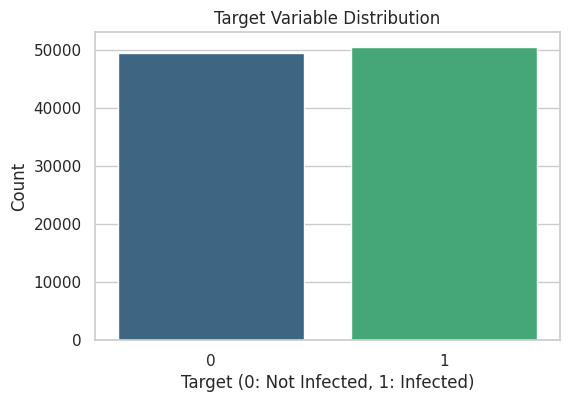

target
1    50.525
0    49.475
Name: proportion, dtype: float64


In [64]:
# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df["target"], palette="viridis")
plt.title("Target Variable Distribution")
plt.xlabel("Target (0: Not Infected, 1: Infected)")
plt.ylabel("Count")
plt.show()

# Percentage of each class
class_distribution = train_df["target"].value_counts(normalize=True) * 100
print(class_distribution)

## 📌 Key Observations
*  The target variable is nearly balanced, with about 50.525% instances labeled as 1 (Infected) and 49.475% labeled as 0 (Not Infected).

In [65]:
# Show all columns with their data types properly
print(train_df.dtypes.to_string())

MachineID                              object
ProductName                            object
EngineVersion                          object
AppVersion                             object
SignatureVersion                       object
IsBetaUser                              int64
RealTimeProtectionState               float64
IsPassiveModeEnabled                    int64
AntivirusConfigID                     float64
NumAntivirusProductsInstalled         float64
NumAntivirusProductsEnabled           float64
HasTpm                                  int64
CountryID                               int64
CityID                                float64
GeoRegionID                           float64
LocaleEnglishNameID                     int64
PlatformType                           object
Processor                              object
OSVersion                              object
OSBuildNumber                           int64
OSProductSuite                          int64
OsPlatformSubRelease              

## 📌 Key Observations
76 columns in total.
Mixed Data Types:
1. Categorical (object): ProductName, OSVersion, PlatformType, etc.

2. Numerical (float64/int64): ProcessorCoreCount, TotalPhysicalRAMMB, target, etc.

## 🎯 Exploratory Data Analysis (EDA)

In [66]:
print(train_df.describe())  # Summary stats for numerical columns
print(train_df.describe(include='object'))  # Summary for categorical columns

       IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%         53447.000000         

## 📌 key observations

1. Data Characteristics
* Size: 100,000 rows, 48 numerical columns, and several categorical columns.
* Target variable: target (binary classification, 0 or 1, almost balanced at ~50% each).
* Many missing values: Some columns have less than 100,000 values (e.g., CityID, IsGamer).
* Mix of categorical and numerical data: Many ID-like columns (CountryID, CityID, etc.), likely categorical but represented as numbers.

2. Possible Issues
*  Features With Constant Values
IsBetaUser is always 0, so it provides no useful information → Drop this column.
HasTpm is almost always 1 (99.7%), so it may not help much → Low variance, consider dropping.
*  High Cardinality Columns (Too Many Unique Values)
MachineID has almost all unique values → Drop (not useful for ML).
OSBuildLab, DateOS, DateAS have many unique values → May need encoding or date-based features.
*  Skewed or Binary Categorical Columns
IsPassiveModeEnabled, IsVirtualDevice, IsGamer, IsSecureBootEnabled, etc., are mostly 0s.


Missing Values Percentage:
 SMode                                 0.981
CityID                                0.623
IsGamer                               0.559
RegionIdentifier                      0.559
InternalBatteryNumberOfCharges        0.515
FirmwareManufacturerID                0.376
FirmwareVersionID                     0.334
IsFlightsDisabled                     0.326
OEMModelID                            0.228
OEMNameID                             0.212
FirewallEnabled                       0.166
TotalPhysicalRAMMB                    0.151
IsAlwaysOnAlwaysConnectedCapable      0.134
OSInstallLanguageID                   0.113
SystemVolumeCapacityMB                0.110
PrimaryDiskCapacityMB                 0.110
IEVersionID                           0.107
ProcessorModelID                      0.085
ProcessorManufacturerID               0.085
ProcessorCoreCount                    0.085
AntivirusConfigID                     0.076
IsSystemProtected                     0.076
NumA

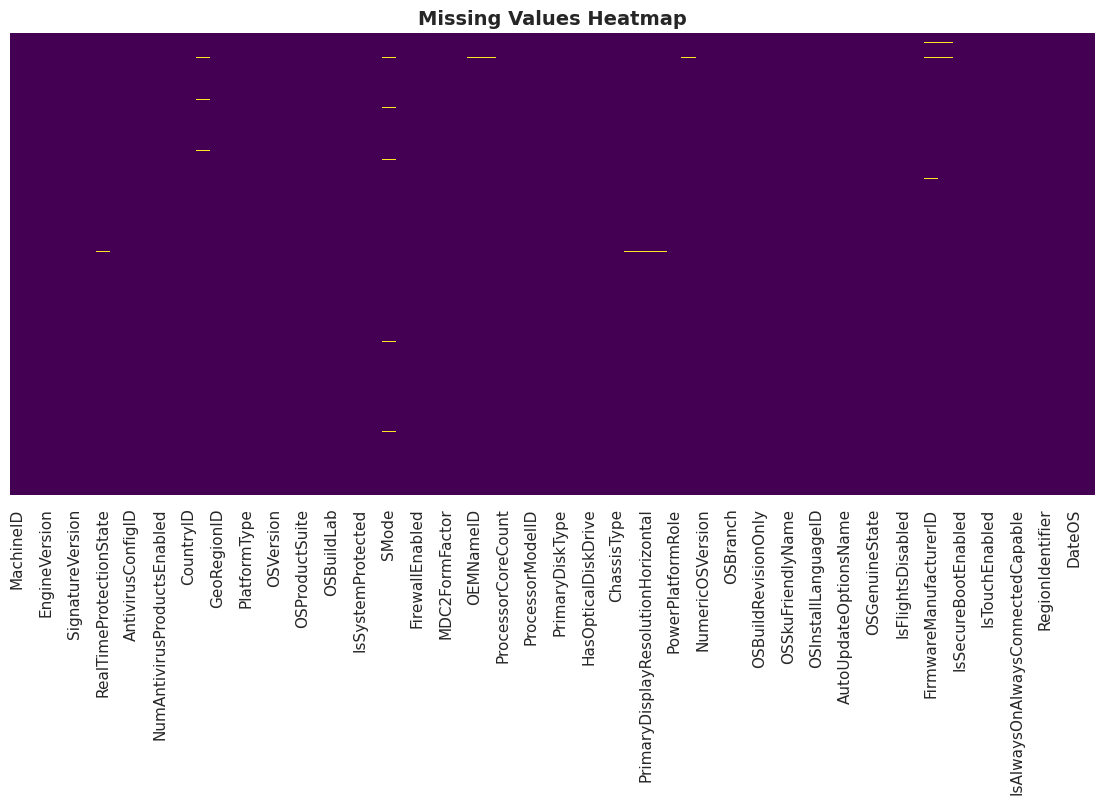

In [67]:
# Set the visual style
sns.set(style="whitegrid")

# Calculate missing values percentage
missing_percent = train_df.isnull().sum() / len(train_df) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

# Print missing value percentages
print("Missing Values Percentage:\n", missing_percent)

# Missing Values Heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(train_df.isnull(), cmap=["#440154", "#FDE725"], cbar=False, yticklabels=False)

# Improve readability
plt.xticks(rotation=90)  # Rotate column names
plt.grid(visible=True, linestyle="--", linewidth=0.5)
plt.title("Missing Values Heatmap", fontsize=14, fontweight="bold")
plt.show()

## 📌 Key Observations
* SMode has the highest missing percentage (0.98%).
* This could be due to some devices not having SMode enabled at all.
* Other important missing values like CityID, IsGamer, RegionIdentifier, InternalBatteryNumberOfCharges have over 0.5% missing values.
* FirmwareManufacturerID, FirmwareVersionID, and IsFlightsDisabled also have a significant number of missing values (~0.3%).
* Many numerical and categorical fields have missing values, but the percentages are quite low.

The missing values heatmap shows sparse missing values (small yellow patches).

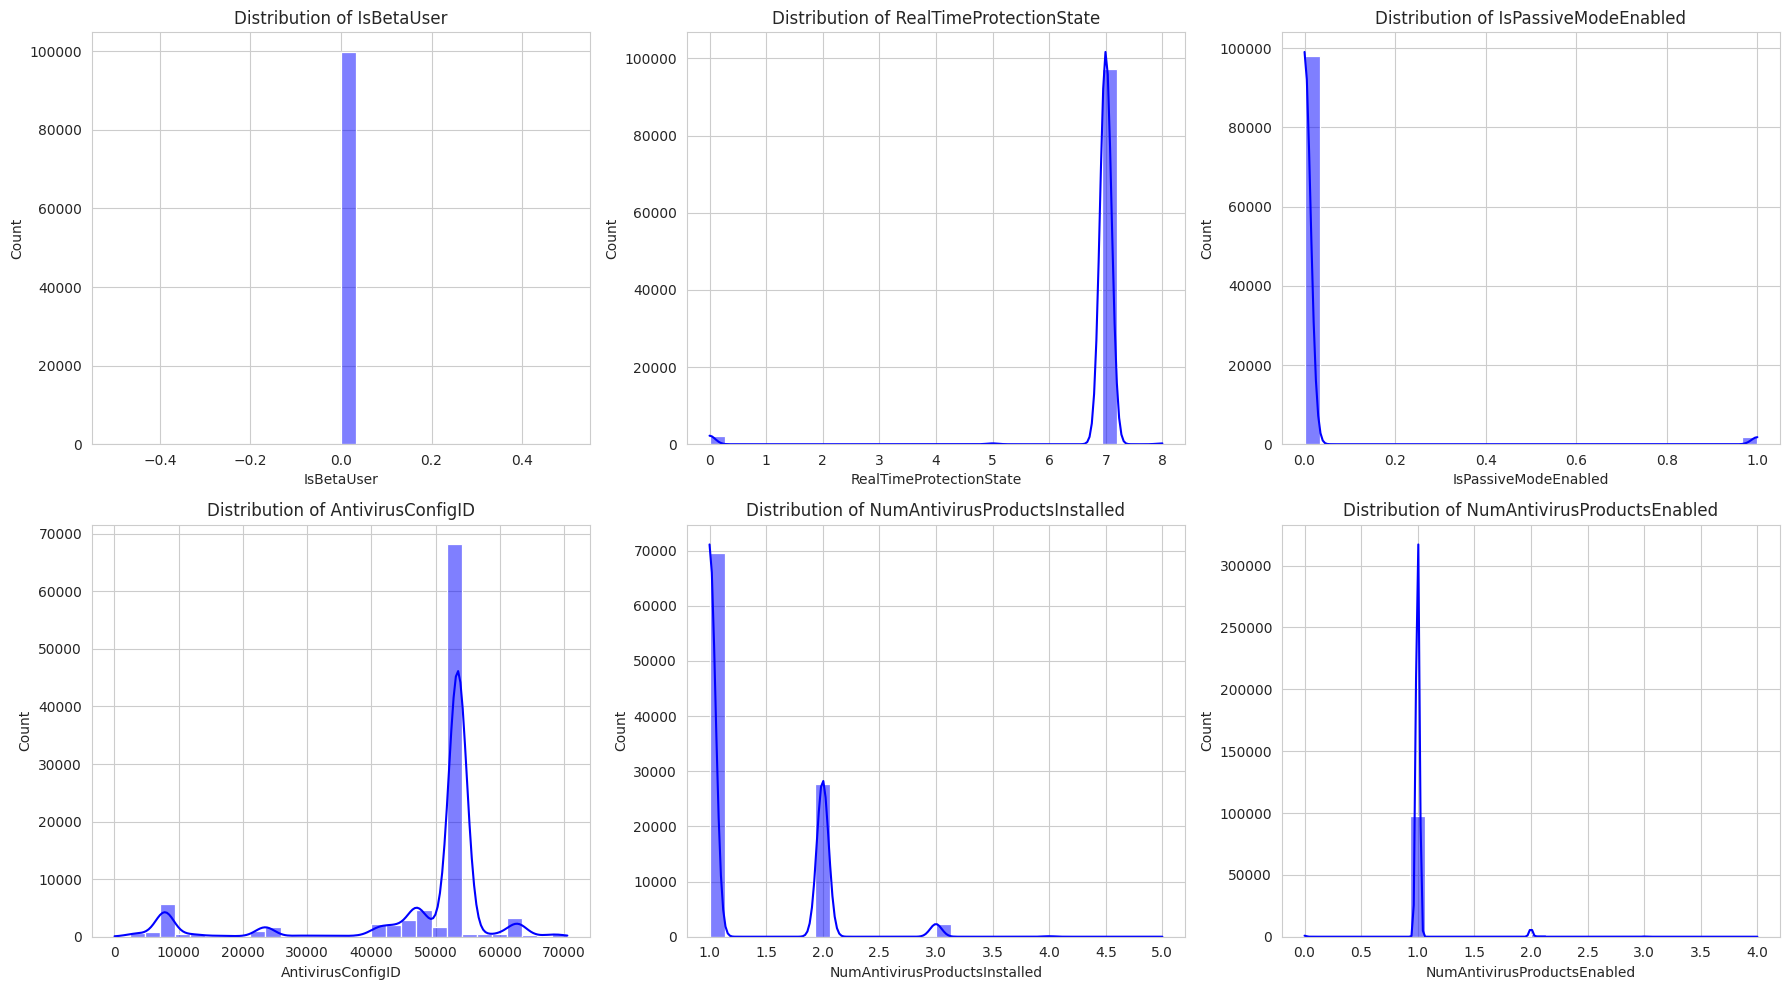

,Feature,Missing Values
25,SMode,981
12,CityID,623
71,RegionIdentifier,559
70,IsGamer,559
46,InternalBatteryNumberOfCharges,515
63,FirmwareManufacturerID,376
64,FirmwareVersionID,334
61,IsFlightsDisabled,326
32,OEMModelID,228
31,OEMNameID,212


In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Summarizing missing values instead of plotting the heatmap
missing_summary = train_df.isnull().sum().reset_index()
missing_summary.columns = ["Feature", "Missing Values"]
missing_summary = missing_summary[missing_summary["Missing Values"] > 0].sort_values(by="Missing Values", ascending=False)

# Distribution of numerical features (selecting a few for visualization)
numerical_features = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Selecting the first 6 numerical features for visualization
num_features_sample = numerical_features[:6]

# Plotting distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(num_features_sample):
    sns.histplot(train_df[col].dropna(), bins=30, kde=True, ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Show missing values summary
missing_summary

## 📌 Key Observations 

From the distributions in the image, here are some observations:

1. IsBetaUser & IsPassiveModeEnabled:
* Both are binary (0 or 1), with a high imbalance (almost all values are 0).
* This could mean very few users have beta versions or passive mode enabled.
  
2. RealTimeProtectionState:
* Most values are clustered around 6-8.
* Very few systems have lower values.
  
3. AntivirusConfigID & NumAntivirusProductsInstalled:
* AntivirusConfigID is highly skewed, with peaks around specific values.
* NumAntivirusProductsInstalled mostly has values 1 or 2, with very few having 3 or more.
  
4. NumAntivirusProductsEnabled:
* Almost all values are around 1, suggesting most systems have only one active antivirus.

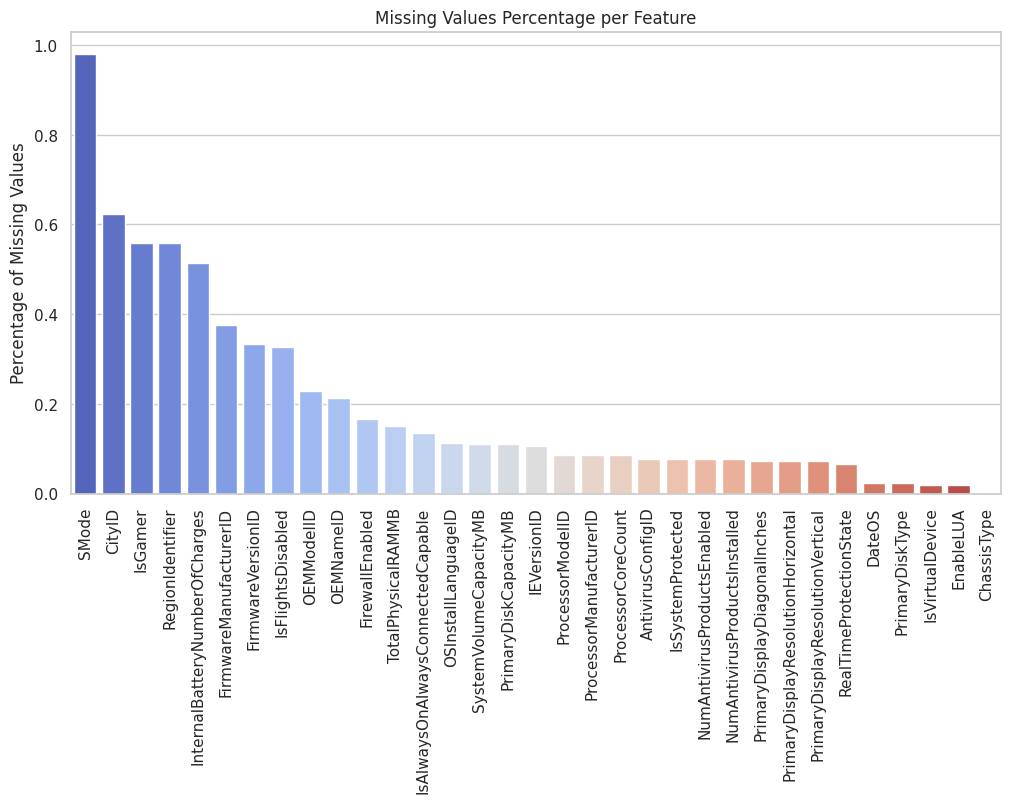

In [69]:
# Missing Values Summary 
missing_values = train_df.isnull().sum() / len(train_df) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values, palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Missing Values")
plt.title("Missing Values Percentage per Feature")
plt.show()

## 📌 Key Observations

1. Features with very high missingness:

* SMode (90%), CityID (65%) are having high missing values.

*  These may need to be dropped, imputed carefully, or further investigated.

2. Moderately missing:

* Features like IsGamer, RegionIdentifier, InternalBatteryNumberOfCharges, etc. have between 30–60% missing values.

*  These may still be useful if you can fill missing values using imputation (e.g., mean, mode, or model-based).

3. Low or negligible missingness:

* Towards the right of the chart, features like PrimaryDiskType, OS, IsVirtualDevice, etc. have <5% missing data.

*  These can often be handled with simple imputations or may be safe to keep as-is.

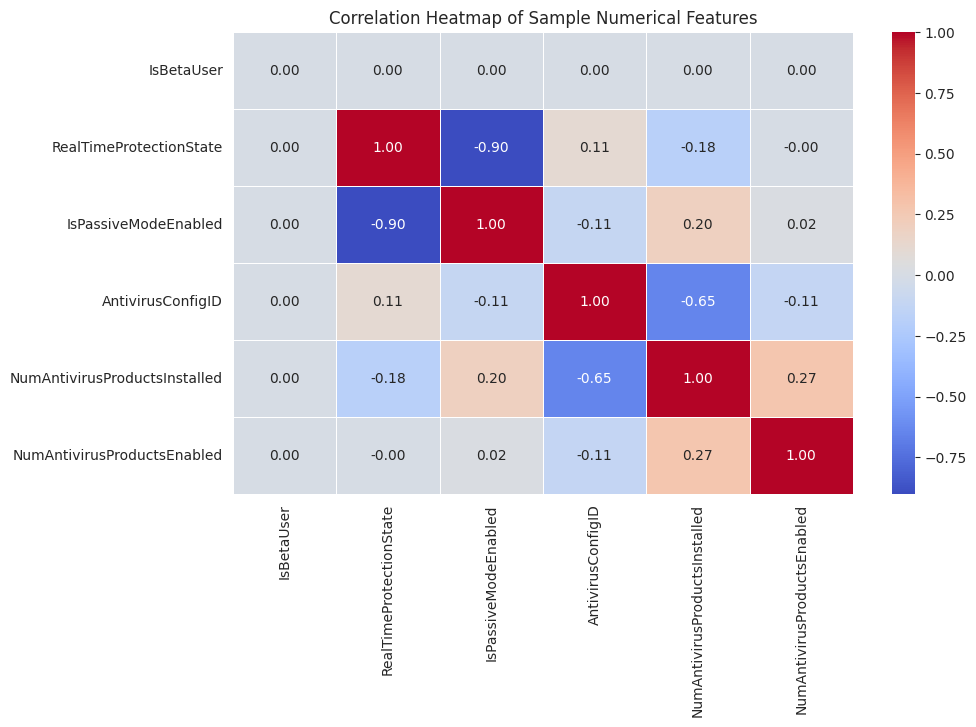

In [21]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Compute correlation matrix for numerical features
corr_matrix = train_df[num_features_sample].corr()

# Replace inf/-inf with NaN and fill remaining NaNs with 0
corr_matrix.replace([np.inf, -np.inf], np.nan, inplace=True)
corr_matrix.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Sample Numerical Features")
plt.show()

## 📌 Key Observations

This heatmap shows the correlation between different numerical features in the dataset. Here are some key observations:

* Strong Negative Correlation (-0.90) Between RealTimeProtectionState & IsPassiveModeEnabled

This suggests that when RealTimeProtectionState is active, IsPassiveModeEnabled is usually inactive, and vice versa.
* Moderate Negative Correlation (-0.65) Between AntivirusConfigID & NumAntivirusProductsInstalled

This may indicate that certain antivirus configurations are associated with fewer installed antivirus products.

* Moderate Positive Correlation (0.27) Between NumAntivirusProductsInstalled & NumAntivirusProductsEnabled

This makes sense since having more antivirus products installed likely means more are enabled.
Other Features Show Weak or No Correlation

The remaining values are close to 0, suggesting weak linear relationships between those features.

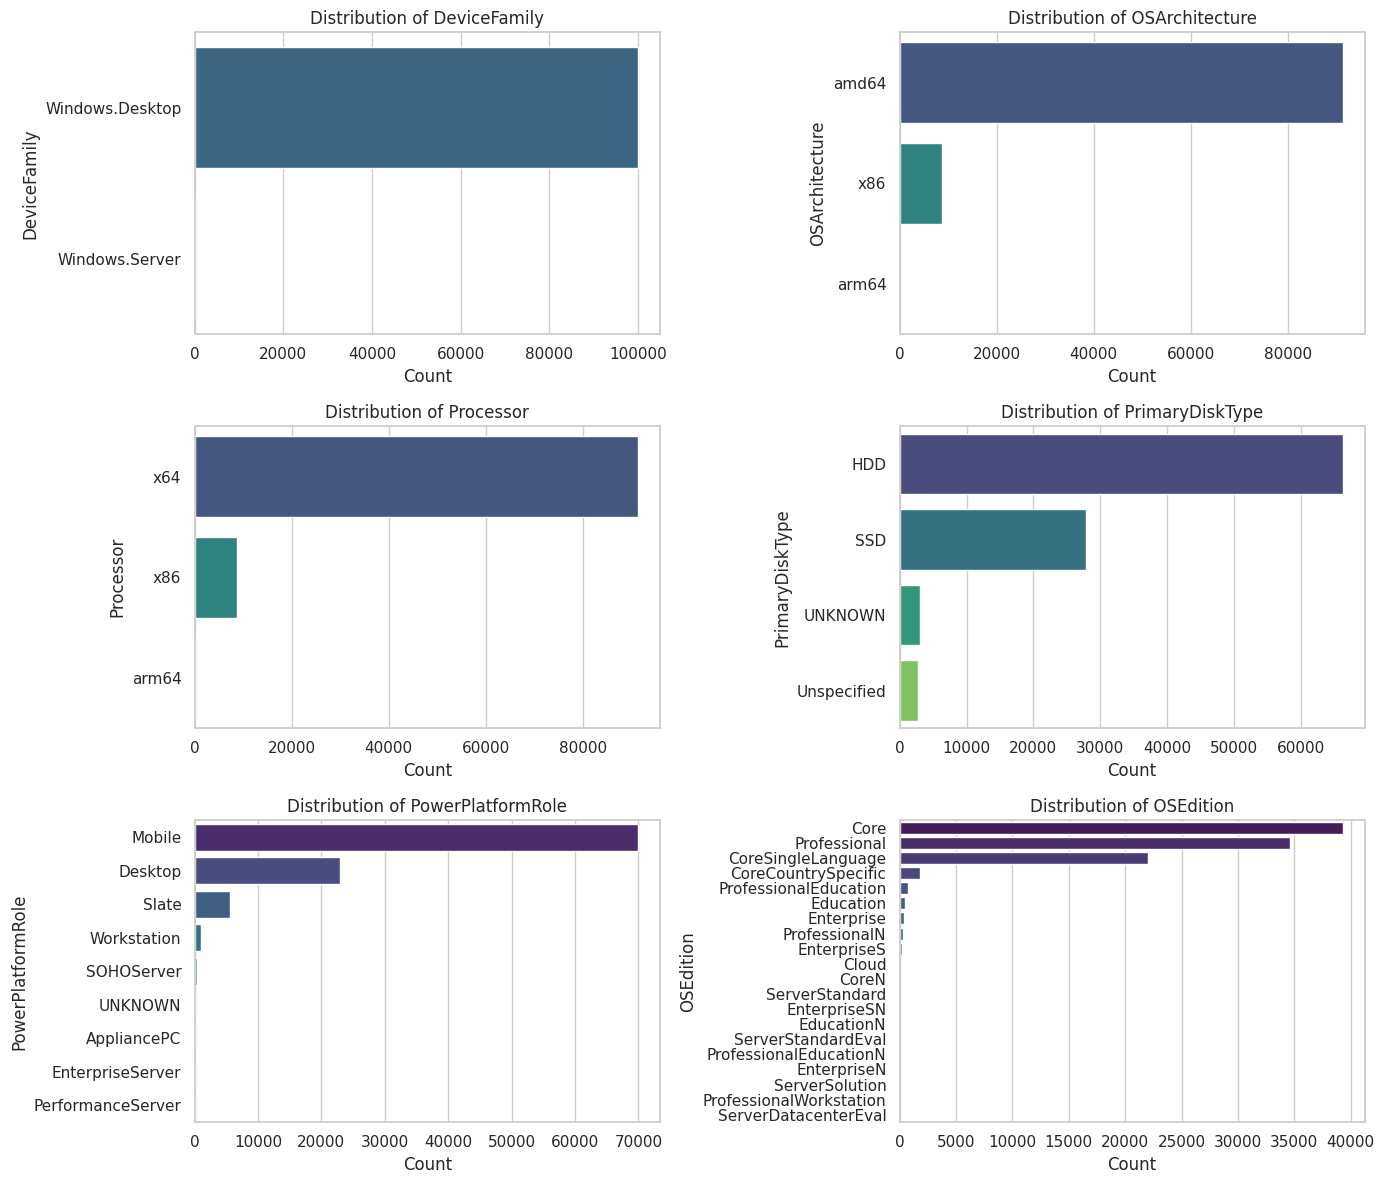

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select some important categorical features for visualization (low to medium cardinality)
selected_categorical_features = [
    "DeviceFamily", "OSArchitecture", "Processor", "PrimaryDiskType",
    "PowerPlatformRole", "OSEdition", "OSGenuineState"
]

# Plot bar charts for selected categorical features
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(selected_categorical_features[:6]):
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


## 📌 Key Observations

Here are the categorical feature distributions:

* DeviceFamily, OSArchitecture, and Processor:

DeviceFamily is dominated by a single category.
OSArchitecture and Processor show a clear preference for specific values.
* PrimaryDiskType and PowerPlatformRole:

PrimaryDiskType has a strong skew, likely favoring HDD or SSD.
PowerPlatformRole suggests most devices belong to a specific category (e.g., "Desktop").
* OSEdition and OSGenuineState:

OSEdition has a few dominant versions.
OSGenuineState shows a strong bias towards one value (probably "Genuine").

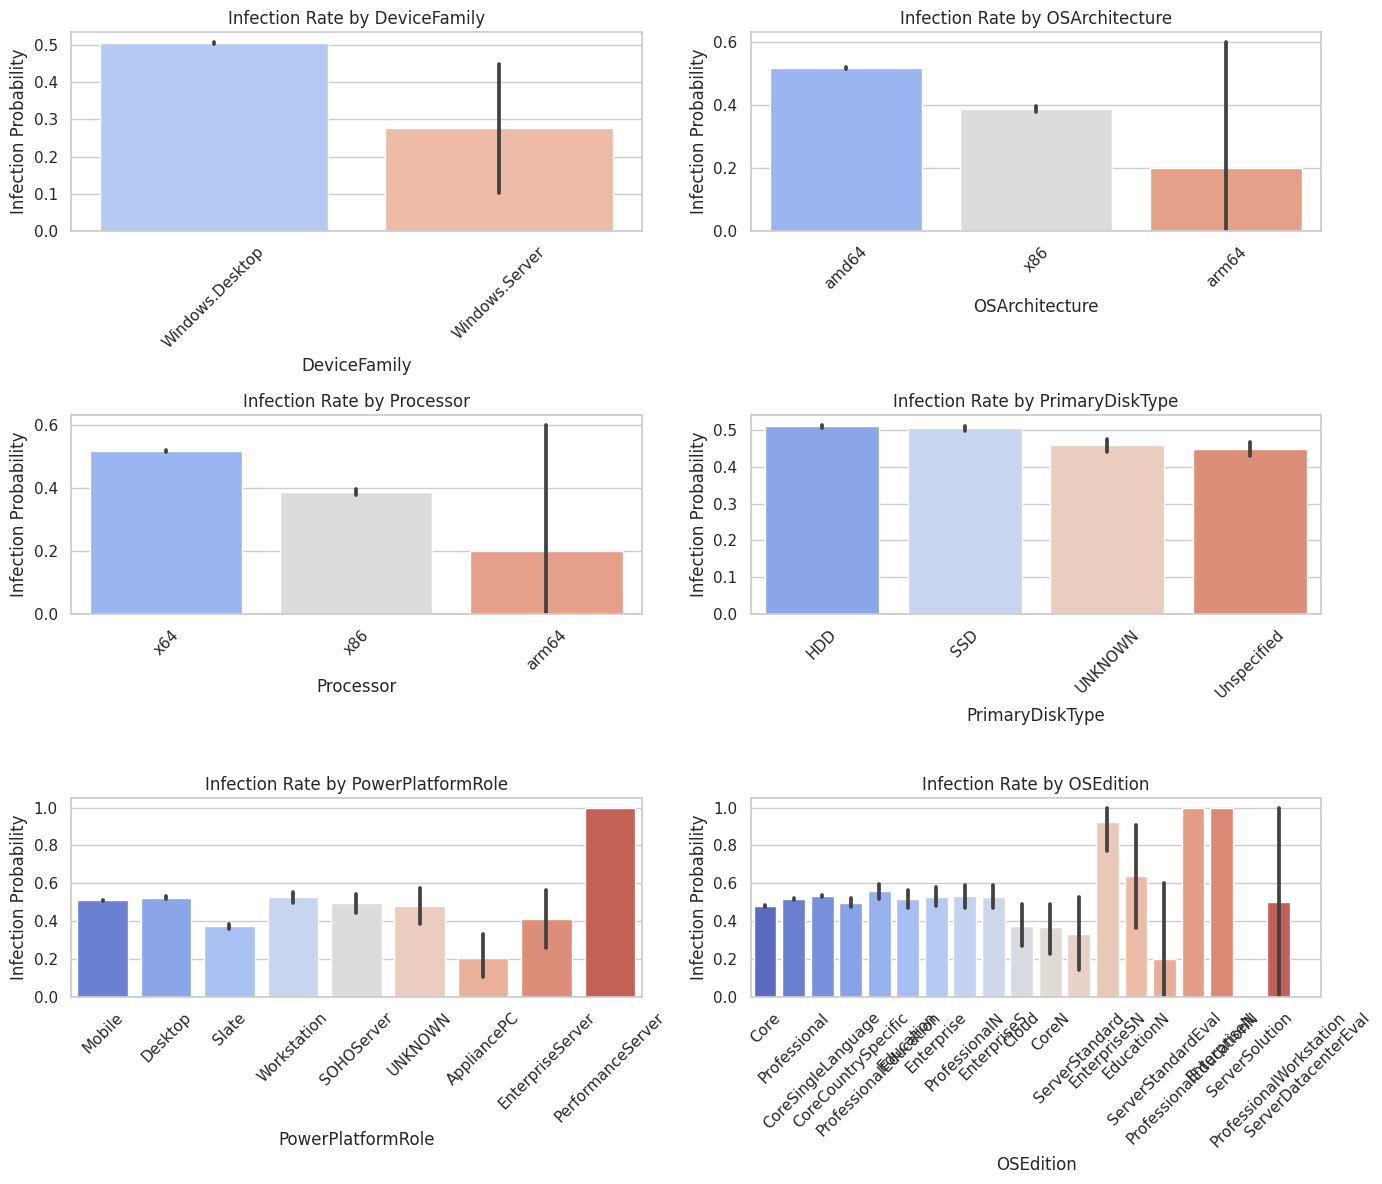

In [72]:
# Plot categorical features against the target variable
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(selected_categorical_features[:6]):
    sns.barplot(x=train_df[col], y=train_df["target"], order=train_df[col].value_counts().index, ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"Infection Rate by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Infection Probability")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 📌 Key Observations

These bar plots show how different categorical features correlate with infection probability:

* OSArchitecture and Processor: Minimal variation in infection rates across categories.
* PrimaryDiskType: Certain disk types might have a slightly higher infection probability.
* PowerPlatformRole and OSEdition: Some categories exhibit a notably higher infection rate, indicating a potential risk factor.
* OSGenuineState: Non-genuine OS versions likely have higher infection rates.

The black lines on the bars in the bar plots represent error bars, which indicate the uncertainty or variability in the estimated infection probability.

In [73]:
# Step 1: Data Inspection
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.info())

Train shape: (100000, 76)
Test shape: (10000, 75)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 n

## 🎯 Data Preprocessing

In [6]:
# Data Preprocessing
# Drop MachineID (not useful for prediction)
train_df.drop(columns=['MachineID'], inplace=True)
test_df.drop(columns=['MachineID'], inplace=True)

# Convert Date columns to datetime format
for df in [train_df, test_df]:
    df['DateAS'] = pd.to_datetime(df['DateAS'], errors='coerce')
    df['DateOS'] = pd.to_datetime(df['DateOS'], errors='coerce')

    # Extract meaningful features from date columns
    df['AS_Year'] = df['DateAS'].dt.year
    df['AS_Month'] = df['DateAS'].dt.month
    df['OS_Year'] = df['DateOS'].dt.year
    df['OS_Month'] = df['DateOS'].dt.month

    df.drop(columns=['DateAS', 'DateOS'], inplace=True)

## 📌 Explanation of the Code
This code is performing **feature engineering** on date columns (DateAS and DateOS) in two datasets: train_df and test_df.

* pd.to_datetime() converts the date columns from string format to datetime format.
* errors='coerce': If any invalid date value is present, it will be converted to NaT (Not a Time) instead of causing an error.

*  Why?
1. Makes it easier to extract year, month, etc.
2. Standardizes the format for further processing.

* .dt.year: Extracts the year from the datetime column.
* .dt.month: Extracts the month from the datetime column.

*  Why?
1. Converts dates into numerical values, which are easier to use in ML models.
2. Helps models detect seasonality patterns (e.g., monthly trends).   


## 🎯 Handling Missing Values

In [7]:
# Handling Missing Values
# Drop columns with more than 50% missing values
missing_threshold = 50
missing_percentage = (train_df.isnull().sum() / len(train_df)) * 100
cols_to_drop = missing_percentage[missing_percentage > missing_threshold].index.tolist()

train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

# Drop duplicate rows
train_df.drop_duplicates(inplace=True)

* The code sets a threshold of 50% for missing values.

* If a column has more than 50% missing values, it will be removed.

* train_df.isnull().sum() → Counts the number of missing (NaN) values in each column.

* len(train_df) → Gets the total number of rows in train_df.

* (train_df.isnull().sum() / len(train_df)) * 100 → Converts missing counts into percentages.

* missing_percentage > missing_threshold → Filters columns with more than 50% missing data.

* .index.tolist() → Extracts the column names as a list.

* Drops the identified columns from both train_df and test_df.

* inplace=True → Makes the change directly in the DataFrame.

* Removes duplicate rows in train_df.

* inplace=True → Modifies the DataFrame directly.



## 🎯 Feature Selection

In [8]:
# Step 3: Feature Selection
# Separate features and target
X = train_df.drop(columns=["target"])
y = train_df["target"]

# Identify numerical and categorical columns

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

**train_df** is the dataset containing all features and the target variable.

We separate the features (X) and target (y):

* X → All columns except "target" (features).

* y → The "target" column (what we want to predict).

We identify numerical and categorical columns from X based on their data types:

select_dtypes(include=["int64", "float64"]) → Selects numerical columns.

select_dtypes(include=["object"]) → Selects categorical columns.

.columns.tolist() → Converts the column names into a list.



## 🎯 Train-Test Split

In [9]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 🎯 Preprocessing Pipeline

In [10]:
# Preprocessing Pipeline
# Define transformers
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

This code defines a data preprocessing pipeline using **Pipeline** and **ColumnTransformer** to handle both numerical and categorical features before feeding them into a machine learning model.

**Step 1**: Define Transformers for Numerical Features
  
This Pipeline processes numerical columns (num_cols) using:

1. Imputation (SimpleImputer)

* Handles missing values by replacing them with the median of the column.
* Why median? Median is robust to outliers (unlike the mean).

2. Scaling (StandardScaler)

* Standardizes numerical values to zero mean and unit variance (z-score normalization).
* Why? Helps ML models converge faster and prevents dominance of large values.

**Step 2**: Define Transformers for Categorical Features

This Pipeline processes categorical columns (cat_cols) using:

1. Imputation (SimpleImputer)

* Replaces missing categorical values with the most frequent value (mode).
* Why? Helps retain the majority class information.

2. Encoding (OrdinalEncoder)

* Converts categorical labels into numerical values.
* Handles unknown categories during inference:
* handle_unknown="use_encoded_value" → Assigns unknown categories a fixed value.
* unknown_value=-1 → Unseen categories are encoded as -1.


## 🎯 MODEL TRAINING ##

## 🚀 logistic Regression ##

 Training Metrics:
Accuracy: 0.5995
AUC: 0.6345
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56     39513
           1       0.59      0.68      0.63     40353

    accuracy                           0.60     79866
   macro avg       0.60      0.60      0.60     79866
weighted avg       0.60      0.60      0.60     79866



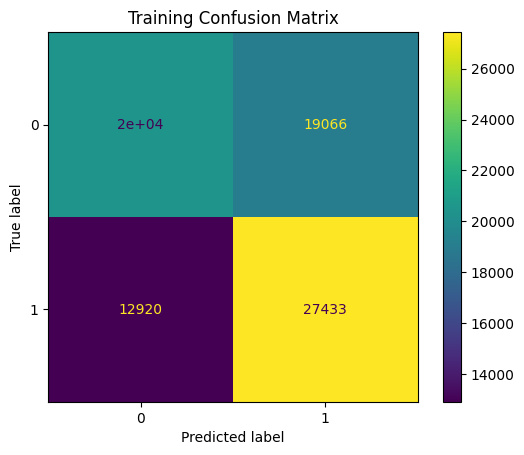


 Validation Metrics:
Accuracy: 0.5932
AUC: 0.6274
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.51      0.55      9878
           1       0.58      0.67      0.63     10089

    accuracy                           0.59     19967
   macro avg       0.59      0.59      0.59     19967
weighted avg       0.59      0.59      0.59     19967



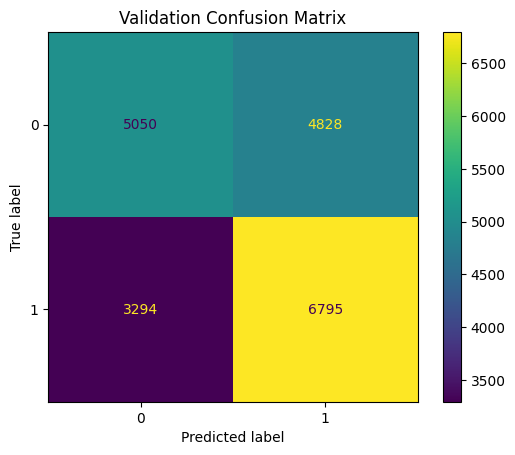

In [35]:
# Define pipeline
log_reg = Pipeline([
    ("preprocessing", preprocessor),  
    ("classifier", LogisticRegression(max_iter=2000, solver="liblinear", C=0.5, random_state=42))
])

# Fit model
log_reg.fit(X_train, y_train)

# Predictions on training set
y_train_pred = log_reg.predict(X_train)
y_train_pred_proba = log_reg.predict_proba(X_train)[:, 1]

# Predictions on validation set
y_val_pred = log_reg.predict(X_val)
y_val_pred_proba = log_reg.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print("Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Confusion matrix for training
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Training Confusion Matrix")
plt.show()

# --- Validation Metrics ---
print("\n Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix for validation
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix")
plt.show()

* Pipeline → A sequential workflow that applies preprocessing before feeding data into the model.

* preprocessor → Handles feature transformations like scaling, encoding, and imputation.

LogisticRegression Parameters:

* max_iter=2000 → Increases the number of iterations to ensure convergence (default is 100).

* solver="liblinear" → A solver optimized for smaller datasets and binary classification.

* C=0.5 → Controls regularization strength (lower values add more regularization, reducing overfitting).

random_state=42 → Ensures reproducibility.

## 🚀Random Forest

 Random Forest - Training Metrics:
Accuracy: 0.7678
AUC: 0.8532
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.66      0.74     39513
           1       0.72      0.87      0.79     40353

    accuracy                           0.77     79866
   macro avg       0.78      0.77      0.76     79866
weighted avg       0.78      0.77      0.77     79866



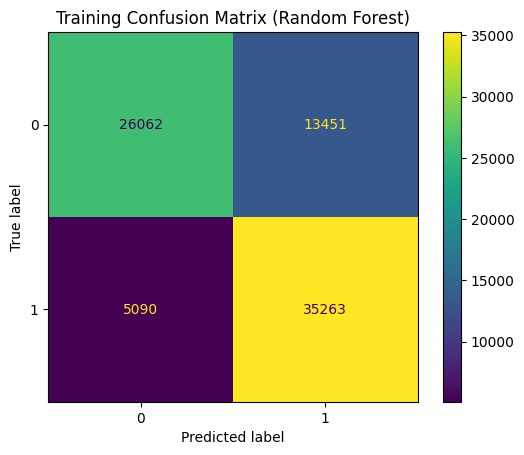

\ Random Forest - Validation Metrics:
Accuracy: 0.6133
AUC: 0.6638
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.54      0.58      9878
           1       0.60      0.68      0.64     10089

    accuracy                           0.61     19967
   macro avg       0.61      0.61      0.61     19967
weighted avg       0.61      0.61      0.61     19967



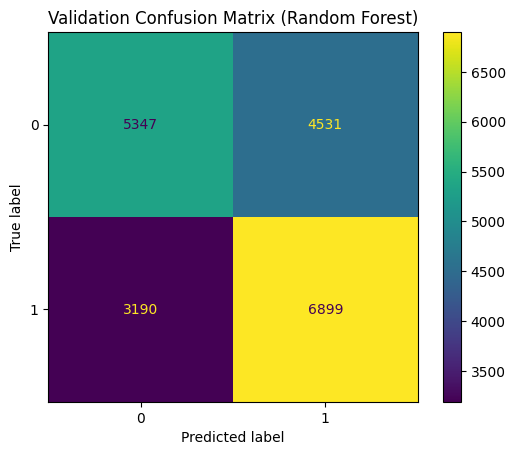

In [37]:
rf_model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        class_weight="balanced"
    ))
])

# Fit model
rf_model.fit(X_train, y_train)

# Predictions on training set
y_train_pred_rf = rf_model.predict(X_train)
y_train_pred_rf_proba = rf_model.predict_proba(X_train)[:, 1]

# Predictions on validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_rf_proba = rf_model.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print(" Random Forest - Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_rf_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred_rf))

# Confusion matrix for training
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
disp_train_rf = ConfusionMatrixDisplay(confusion_matrix=cm_train_rf)
disp_train_rf.plot()
plt.title("Training Confusion Matrix (Random Forest)")
plt.show()

# --- Validation Metrics ---
print("\ Random Forest - Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_rf_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

# Confusion matrix for validation
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
disp_val_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf)
disp_val_rf.plot()
plt.title("Validation Confusion Matrix (Random Forest)")
plt.show()

* Pipeline: Ensures preprocessing and model training happen together.

* RandomForestClassifier: Uses an ensemble of decision trees to improve prediction.

Hyperparameters:

* n_estimators=200: Uses 200 trees to reduce variance.

* max_depth=15: Prevents trees from growing too deep (overfitting).

* min_samples_split=5: Ensures at least 5 samples per split.

* random_state=42: Ensures reproducibility.

* class_weight="balanced": Handles class imbalance.

## 🚀lightgbm

 LightGBM - Training Metrics:
Accuracy: 0.6919
AUC: 0.7654
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.64      0.67     39513
           1       0.68      0.74      0.71     40353

    accuracy                           0.69     79866
   macro avg       0.69      0.69      0.69     79866
weighted avg       0.69      0.69      0.69     79866



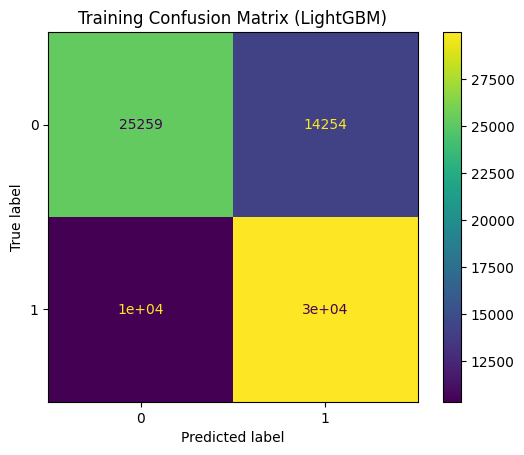


 LightGBM - Validation Metrics:
Accuracy: 0.6226
AUC: 0.6750
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      9878
           1       0.62      0.67      0.64     10089

    accuracy                           0.62     19967
   macro avg       0.62      0.62      0.62     19967
weighted avg       0.62      0.62      0.62     19967



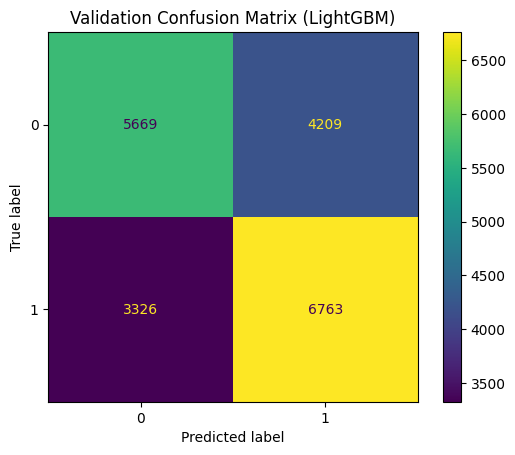

In [38]:
lgb_model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=30,
        colsample_bytree=0.8,
        subsample=0.8,
        random_state=42
    ))
])

# Fit the model
lgb_model.fit(X_train, y_train)

# Predictions on training set
y_train_pred_lgb = lgb_model.predict(X_train)
y_train_pred_lgb_proba = lgb_model.predict_proba(X_train)[:, 1]

# Predictions on validation set
y_val_pred_lgb = lgb_model.predict(X_val)
y_val_pred_lgb_proba = lgb_model.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print(" LightGBM - Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_lgb):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_lgb_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred_lgb))

# Confusion matrix for training
cm_train_lgb = confusion_matrix(y_train, y_train_pred_lgb)
disp_train_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_train_lgb)
disp_train_lgb.plot()
plt.title("Training Confusion Matrix (LightGBM)")
plt.show()

# --- Validation Metrics ---
print("\n LightGBM - Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_lgb):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_lgb_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_lgb))

# Confusion matrix for validation
cm_val_lgb = confusion_matrix(y_val, y_val_pred_lgb)
disp_val_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_val_lgb)
disp_val_lgb.plot()
plt.title("Validation Confusion Matrix (LightGBM)")
plt.show()

* lightgbm: A gradient boosting library optimized for speed and efficiency

* n_estimators=500: Uses 500 boosting rounds to improve performance.

* learning_rate=0.05: Controls how much the model adjusts in each iteration.

* max_depth=7: Prevents overfitting by limiting tree depth.

* num_leaves=30: Determines the complexity of trees (higher values capture more patterns).

* colsample_bytree=0.8: Uses 80% of features per tree to prevent overfitting.

* subsample=0.8: Uses 80% of the training data for each boosting round.

* random_state=42: Ensures the results are reproducible.

## 🚀 Optimized LightGBM Model

 Optimized LightGBM - Training Metrics:
Accuracy: 0.7517
AUC: 0.8366
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.74     39513
           1       0.73      0.80      0.76     40353

    accuracy                           0.75     79866
   macro avg       0.75      0.75      0.75     79866
weighted avg       0.75      0.75      0.75     79866



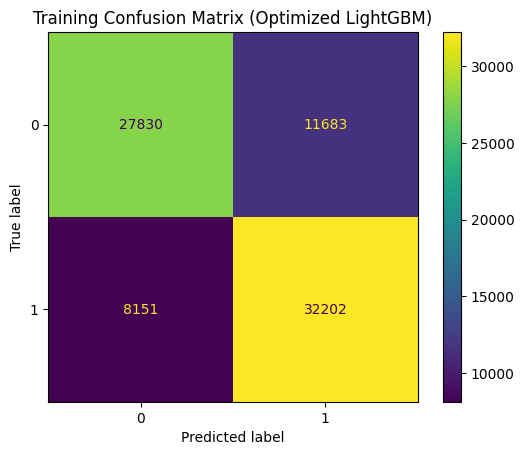


 Optimized LightGBM - Validation Metrics:
Accuracy: 0.6242
AUC: 0.6755
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.61      9878
           1       0.62      0.67      0.64     10089

    accuracy                           0.62     19967
   macro avg       0.62      0.62      0.62     19967
weighted avg       0.62      0.62      0.62     19967



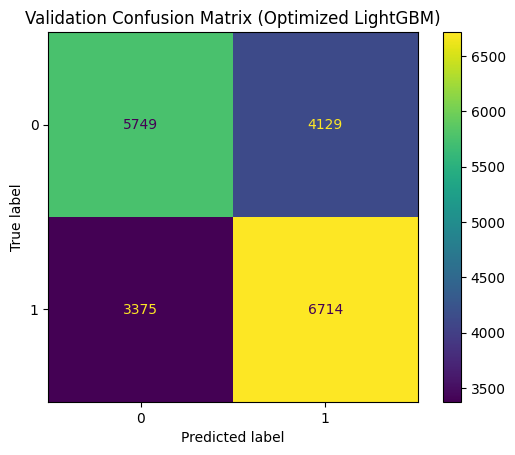


📊 Cross-Validation:
Mean AUC: 0.6775 ± 0.0036


In [39]:
# Define Optimized LightGBM pipeline
lgb_model_optimized = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        max_depth=10,
        num_leaves=50,
        min_child_samples=30,
        colsample_bytree=0.8,
        subsample=0.8,
        random_state=42
    ))
])

# Fit the model
lgb_model_optimized.fit(X_train, y_train)

# Predictions on training set
y_train_pred_opt = lgb_model_optimized.predict(X_train)
y_train_proba_opt = lgb_model_optimized.predict_proba(X_train)[:, 1]

# Predictions on validation set
y_val_pred_opt = lgb_model_optimized.predict(X_val)
y_val_proba_opt = lgb_model_optimized.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print(" Optimized LightGBM - Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_opt):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_opt):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred_opt))

# Confusion matrix for training
cm_train_opt = confusion_matrix(y_train, y_train_pred_opt)
disp_train_opt = ConfusionMatrixDisplay(confusion_matrix=cm_train_opt)
disp_train_opt.plot()
plt.title("Training Confusion Matrix (Optimized LightGBM)")
plt.show()

# --- Validation Metrics ---
print("\n Optimized LightGBM - Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_opt):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_proba_opt):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_opt))

# Confusion matrix for validation
cm_val_opt = confusion_matrix(y_val, y_val_pred_opt)
disp_val_opt = ConfusionMatrixDisplay(confusion_matrix=cm_val_opt)
disp_val_opt.plot()
plt.title("Validation Confusion Matrix (Optimized LightGBM)")
plt.show()

# --- Cross-validation AUC ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgb_model_optimized, X, y, cv=cv, scoring='roc_auc')

print("\n📊 Cross-Validation:")
print(f"Mean AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

* Pipeline: Combines preprocessing and LightGBM model.

* n_estimators=1000: Increased number of trees improves generalization.

* learning_rate=0.03: Smaller steps reduce overfitting and allow better convergence.

* max_depth=10: Allows deeper trees to capture more complex patterns.

* num_leaves=50: More leaves help capture finer details.

* min_child_samples=30: Ensures splits only happen when enough data points are available.

* colsample_bytree=0.8: Uses 80% of features in each tree to reduce overfitting.

* subsample=0.8: Uses 80% of data in each boosting iteration for better robustness.

5-fold Stratified Cross-Validation is performed to:

* Train and validate on different splits.

* Get a more generalized estimate of model performance.

* roc_auc is used as the evaluation metric.

## 🚀 xgboost

 XGBoost - Training Metrics:
Accuracy: 0.8864
AUC: 0.9566
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     39513
           1       0.86      0.92      0.89     40353

    accuracy                           0.89     79866
   macro avg       0.89      0.89      0.89     79866
weighted avg       0.89      0.89      0.89     79866



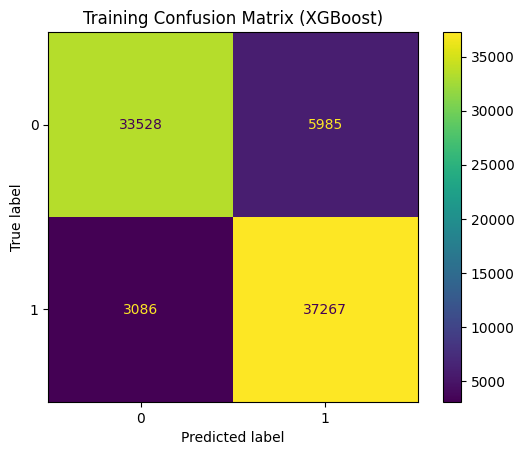


 XGBoost - Validation Metrics:
Accuracy: 0.6191
AUC: 0.6678
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.60      9878
           1       0.62      0.65      0.63     10089

    accuracy                           0.62     19967
   macro avg       0.62      0.62      0.62     19967
weighted avg       0.62      0.62      0.62     19967



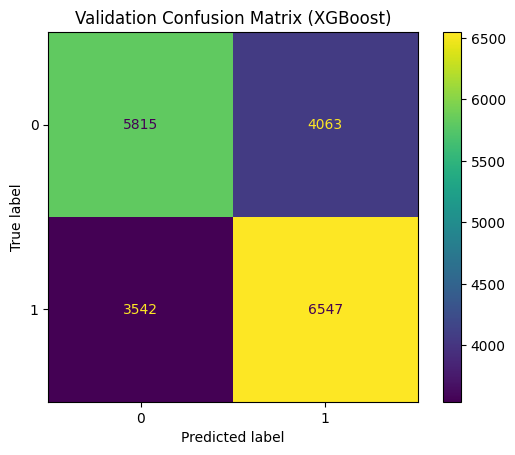


📊 Cross-Validation AUC (XGBoost):
Mean AUC: 0.6686 ± 0.0036


In [40]:
# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost Pipeline
xgb_model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", xgb.XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=8,
        colsample_bytree=0.8,
        subsample=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ))
])

# Fit model
xgb_model.fit(X_train, y_train)

# Predictions on training set
y_train_pred_xgb = xgb_model.predict(X_train)
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]

# Predictions on validation set
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print(" XGBoost - Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_xgb):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba_xgb):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred_xgb))

cm_train_xgb = confusion_matrix(y_train, y_train_pred_xgb)
disp_train_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_train_xgb)
disp_train_xgb.plot()
plt.title("Training Confusion Matrix (XGBoost)")
plt.show()

# --- Validation Metrics ---
print("\n XGBoost - Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_xgb):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_proba_xgb):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_xgb))

cm_val_xgb = confusion_matrix(y_val, y_val_pred_xgb)
disp_val_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_val_xgb)
disp_val_xgb.plot()
plt.title("Validation Confusion Matrix (XGBoost)")
plt.show()

# --- Cross-validation AUC ---
cv_xgb = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc')
print("\n📊 Cross-Validation AUC (XGBoost):")
print(f"Mean AUC: {np.mean(cv_xgb):.4f} ± {np.std(cv_xgb):.4f}")

* Pipeline: Combines preprocessing and classification.

* n_estimators=800 → More trees for better learning.

* learning_rate=0.05 → Lower learning rate improves generalization.

* max_depth=8 → Controls tree complexity.

* colsample_bytree=0.8 → Prevents overfitting by using only 80% of features.

* subsample=0.8 → Trains on 80% of data per boosting iteration.

* use_label_encoder=False → Avoids unnecessary warnings.

* eval_metric="logloss" → Measures classification performance.

* random_state=42 → Ensures reproducibility.

* Performs 5-fold cross-validation.



## 🚀 MLP Classifier

Training Metrics:
Accuracy: 0.6006
AUC: 0.6387
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57     39513
           1       0.59      0.66      0.63     40353

    accuracy                           0.60     79866
   macro avg       0.60      0.60      0.60     79866
weighted avg       0.60      0.60      0.60     79866



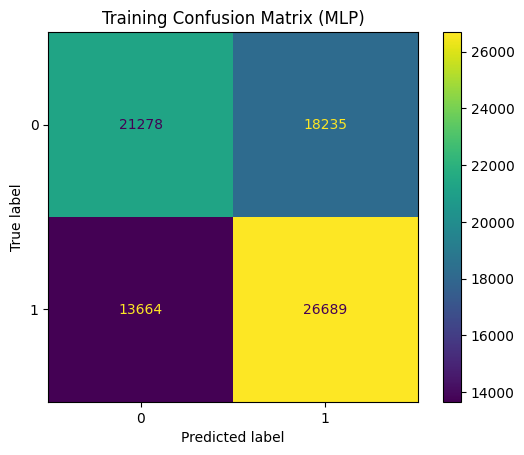


Validation Metrics:
Accuracy: 0.5952
AUC: 0.6307
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.53      0.57      9878
           1       0.59      0.66      0.62     10089

    accuracy                           0.60     19967
   macro avg       0.60      0.59      0.59     19967
weighted avg       0.60      0.60      0.59     19967



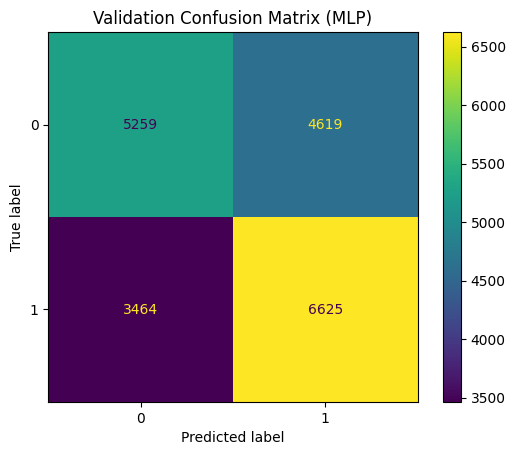

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Define pipeline
mlp_pipeline = Pipeline([
    ("preprocessing", preprocessor),  
    ("classifier", MLPClassifier(
        hidden_layer_sizes=(100,),   # Default single hidden layer with 100 neurons
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ))
])

# Fit model
mlp_pipeline.fit(X_train, y_train)

# --- Training predictions ---
y_train_pred = mlp_pipeline.predict(X_train)
y_train_pred_proba = mlp_pipeline.predict_proba(X_train)[:, 1]

# --- Validation predictions ---
y_val_pred = mlp_pipeline.predict(X_val)
y_val_pred_proba = mlp_pipeline.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print("Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Confusion Matrix - Training
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Training Confusion Matrix (MLP)")
plt.show()

# --- Validation Metrics ---
print("\nValidation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix - Validation
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix (MLP)")
plt.show()


## 🎯 Hyperparameter Tuning for Key Models

## 🚀 Logistic Regression tuning

🛠️ Best Logistic Regression Params: {'classifier__solver': 'liblinear', 'classifier__C': 10}
📈 Best ROC AUC from CV: 0.6322

 Training Metrics:
Accuracy: 0.5994
AUC: 0.6344
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56     39513
           1       0.59      0.68      0.63     40353

    accuracy                           0.60     79866
   macro avg       0.60      0.60      0.60     79866
weighted avg       0.60      0.60      0.60     79866



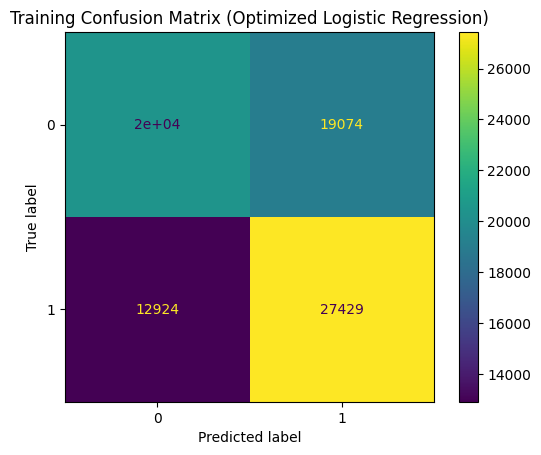


 Validation Metrics:
Accuracy: 0.5934
AUC: 0.6273
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.51      0.55      9878
           1       0.58      0.67      0.63     10089

    accuracy                           0.59     19967
   macro avg       0.60      0.59      0.59     19967
weighted avg       0.59      0.59      0.59     19967



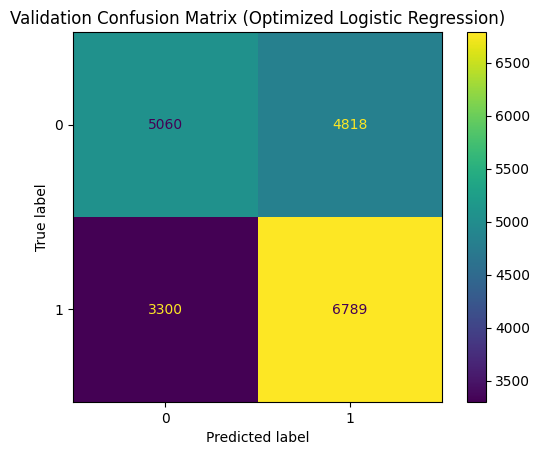

In [42]:
# Define hyperparameter grid
param_dist_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

# Pipeline setup
log_reg_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", LogisticRegression(max_iter=500, random_state=42))
])

# Randomized Search CV
random_search_lr = RandomizedSearchCV(
    log_reg_pipeline,
    param_distributions=param_dist_lr,
    cv=3,
    scoring='roc_auc',
    n_iter=5,
    n_jobs=-1,
    random_state=42
)

# Fit model
random_search_lr.fit(X_train, y_train)

# Best params & score
print("🛠️ Best Logistic Regression Params:", random_search_lr.best_params_)
print(f"📈 Best ROC AUC from CV: {random_search_lr.best_score_:.4f}")

# --- Training predictions ---
y_train_pred = random_search_lr.best_estimator_.predict(X_train)
y_train_pred_proba = random_search_lr.best_estimator_.predict_proba(X_train)[:, 1]

# --- Validation predictions ---
y_val_pred = random_search_lr.best_estimator_.predict(X_val)
y_val_pred_proba = random_search_lr.best_estimator_.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print("\n Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Confusion matrix - train
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Training Confusion Matrix (Optimized Logistic Regression)")
plt.show()

# --- Validation Metrics ---
print("\n Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix - validation
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix (Optimized Logistic Regression)")
plt.show()

* C (Regularization Strength) → Controls the inverse of regularization. Smaller values indicate stronger regularization.

* solver → Algorithm to optimize logistic regression:

* 'liblinear' → Suitable for small datasets.

* 'lbfgs' → Works well for larger datasets.

* Runs the RandomizedSearchCV, training multiple logistic regression models with different hyperparameters.

* best_params_ → Returns the best hyperparameter combination.


n_iter = 5
parameter grid has:

'classifier__C': [0.001, 0.01, 0.1, 1, 10] → 5 values

'classifier__solver': ['liblinear', 'lbfgs'] → 2 values

Total possible combinations = 5 × 2 = 10

But since i am using RandomizedSearchCV with n_iter=5, only 5 random combinations (out of the 10 possible) will be tried.

cv=3

Total model runs = n_iter × cv = 5 × 3 = 15 times

That means the code will train 15 Logistic Regression models in total during the randomized search phase.

## 🚀 Lightbgm tuning

🛠️ Best LightGBM Params: {'classifier__num_leaves': 30, 'classifier__n_estimators': 100, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1}
📈 Best ROC AUC from CV: 0.6736

 Training Metrics:
Accuracy: 0.6552
AUC: 0.7178
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63     39513
           1       0.64      0.71      0.68     40353

    accuracy                           0.66     79866
   macro avg       0.66      0.65      0.65     79866
weighted avg       0.66      0.66      0.65     79866



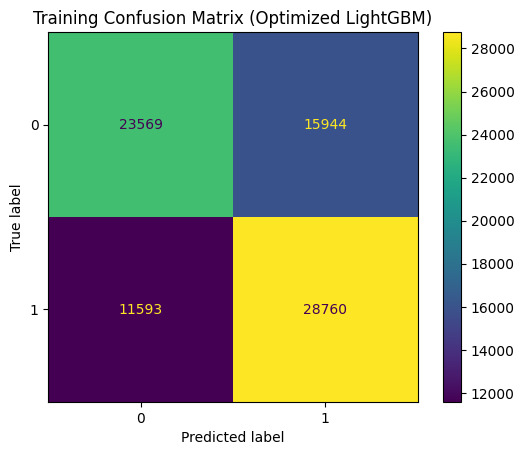


 Validation Metrics:
Accuracy: 0.6214
AUC: 0.6728
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      9878
           1       0.61      0.67      0.64     10089

    accuracy                           0.62     19967
   macro avg       0.62      0.62      0.62     19967
weighted avg       0.62      0.62      0.62     19967



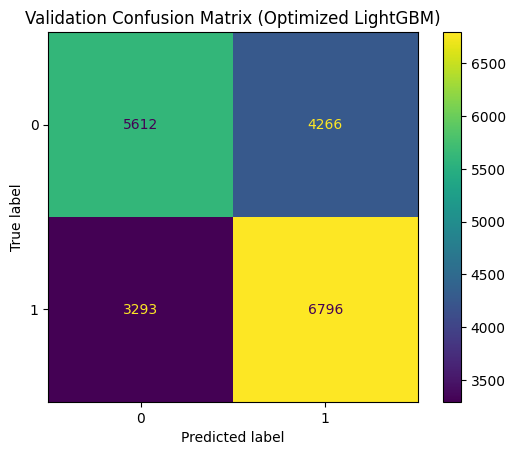

In [43]:
# Define hyperparameter grid
param_dist_lgb = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__num_leaves': [20, 30, 40]
}

# LightGBM Pipeline
lgb_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", lgb.LGBMClassifier(random_state=42))
])

# Randomized Search CV
random_search_lgb = RandomizedSearchCV(
    lgb_pipeline,
    param_distributions=param_dist_lgb,
    cv=3,
    scoring='roc_auc',
    n_iter=5,
    n_jobs=-1,
    random_state=42
)

# Fit model
random_search_lgb.fit(X_train, y_train)

# Best params & score
print("🛠️ Best LightGBM Params:", random_search_lgb.best_params_)
print(f"📈 Best ROC AUC from CV: {random_search_lgb.best_score_:.4f}")

# --- Training predictions ---
y_train_pred = random_search_lgb.best_estimator_.predict(X_train)
y_train_pred_proba = random_search_lgb.best_estimator_.predict_proba(X_train)[:, 1]

# --- Validation predictions ---
y_val_pred = random_search_lgb.best_estimator_.predict(X_val)
y_val_pred_proba = random_search_lgb.best_estimator_.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print("\n Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Confusion matrix - train
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Training Confusion Matrix (Optimized LightGBM)")
plt.show()

# --- Validation Metrics ---
print("\n Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix - validation
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix (Optimized LightGBM)")
plt.show()

RandomizedSearchCV:

* Randomly searches for the best hyperparameters instead of trying all possible combinations (which is slow).

Key Parameters:

* lgb_pipeline: The pipeline (preprocessing + model).

* param_dist_lgb: The hyperparameter search space.

* cv=3: 3-fold cross-validation (splitting data into 3 parts to evaluate performance).

* scoring='roc_auc': Maximizing the AUC-ROC score, which is good for imbalanced datasets.

* n_jobs=-1: Uses all available CPU cores for faster computation.

* n_iter=5: Randomly tests 5 different hyperparameter combinations.


param_dist_lgb = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],       # 3 options
    'classifier__n_estimators': [100, 200],               # 2 options
    'classifier__max_depth': [3, 5, 7],                   # 3 options
    'classifier__num_leaves': [20, 30, 40]                # 3 options
}

3 (learning_rate) × 2 (n_estimators) × 3 (max_depth) × 3 (num_leaves) = 54 combinations
n_iter=5
Out of the 54 total combinations, it will randomly try only 5 combinations.

cv=3
Which means each of those 5 combinations will be trained & validated 3 times, once for each fold.

Final Answer:
Total model fits = n_iter × cv = 5 × 3 = 15 model runs

## 🚀 Random Forest tuning

🛠️ Best Random Forest Params: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 20}
📈 Best ROC AUC from CV: 0.6571

 Training Metrics:
Accuracy: 0.8168
AUC: 0.9113
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80     39513
           1       0.78      0.90      0.83     40353

    accuracy                           0.82     79866
   macro avg       0.83      0.82      0.82     79866
weighted avg       0.82      0.82      0.82     79866



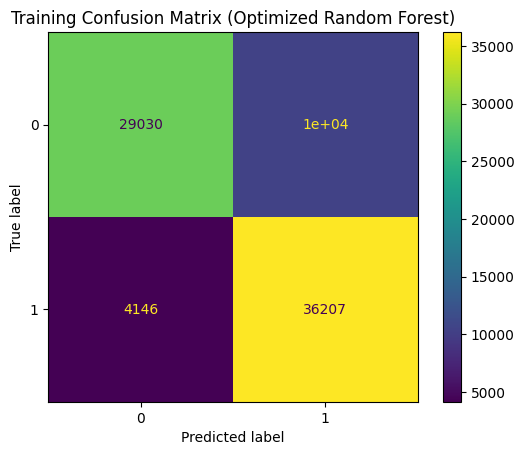


 Validation Metrics:
Accuracy: 0.6123
AUC: 0.6582
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58      9878
           1       0.60      0.68      0.64     10089

    accuracy                           0.61     19967
   macro avg       0.61      0.61      0.61     19967
weighted avg       0.61      0.61      0.61     19967



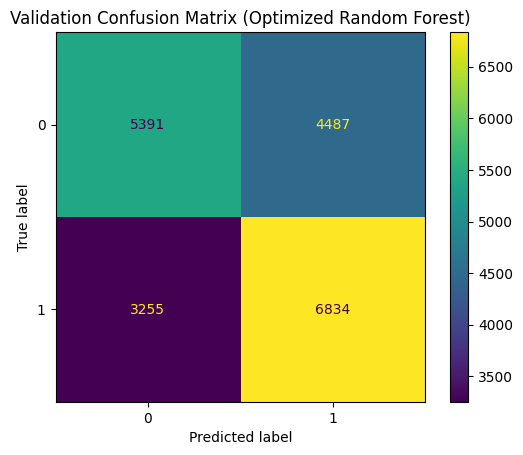

In [44]:
# Hyperparameter space
param_dist_rf = {
    "classifier__n_estimators": [50, 100, 200],   
    "classifier__max_depth": [None, 5, 10, 20],   
    "classifier__min_samples_split": [2, 5, 10],  
    "classifier__min_samples_leaf": [1, 2, 4],    
    "classifier__max_features": ["sqrt", "log2"]  
}

# Pipeline
rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Random Search
random_search_rf = RandomizedSearchCV(
    rf_pipeline, param_distributions=param_dist_rf, 
    cv=2, scoring="roc_auc", n_jobs=1, n_iter=5, random_state=42
)

# Fit model
random_search_rf.fit(X_train, y_train)

# Best params & score
print("🛠️ Best Random Forest Params:", random_search_rf.best_params_)
print(f"📈 Best ROC AUC from CV: {random_search_rf.best_score_:.4f}")

# --- Training predictions ---
y_train_pred = random_search_rf.best_estimator_.predict(X_train)
y_train_pred_proba = random_search_rf.best_estimator_.predict_proba(X_train)[:, 1]

# --- Validation predictions ---
y_val_pred = random_search_rf.best_estimator_.predict(X_val)
y_val_pred_proba = random_search_rf.best_estimator_.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print("\n Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Confusion matrix - training
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Training Confusion Matrix (Optimized Random Forest)")
plt.show()

# --- Validation Metrics ---
print("\n Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix - validation
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix (Optimized Random Forest)")
plt.show()

* RandomForestClassifier: A tree-based ensemble learning method using multiple decision trees.

* RandomizedSearchCV: Performs a random search over a range of hyperparameters to find the best combination.

* n_estimators: More trees can improve performance but increase training time.

* max_depth: Limits tree depth to prevent overfitting.

* min_samples_split: Larger values prevent deep trees.

* min_samples_leaf: Controls leaf node size (higher values reduce overfitting).

* max_features: Determines how many features are considered at each split.

* "sqrt": Uses square root of total features (default for classification).

* "log2": Uses log base 2 of total features.


param_dist_rf = {
    "classifier__n_estimators": [50, 100, 200],            # 3 options
    "classifier__max_depth": [None, 5, 10, 20],            # 4 options
    "classifier__min_samples_split": [2, 5, 10],           # 3 options
    "classifier__min_samples_leaf": [1, 2, 4],             # 3 options
    "classifier__max_features": ["sqrt", "log2"]           # 2 options
}

3 × 4 × 3 × 3 × 2 = 216 total combinations
n_iter = 5
So instead of trying all 216, it randomly samples 5 combinations.
cv = 2
So each of those 5 combinations is trained/validated 2 times (2-fold cross-validation).

Final Answer:
Total model fits = 5 combinations × 2 folds = 10 model runs

## 🚀 Xgb tuning

🛠️ Best XGBoost Params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 30, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.7}
📈 Best ROC AUC from CV: 0.6595

 Training Metrics:
Accuracy: 0.6245
AUC: 0.6756
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.53      0.58     39513
           1       0.61      0.72      0.66     40353

    accuracy                           0.62     79866
   macro avg       0.63      0.62      0.62     79866
weighted avg       0.63      0.62      0.62     79866



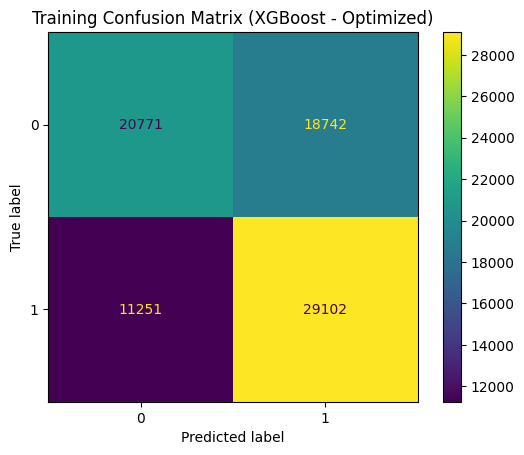


 Validation Metrics:
Accuracy: 0.6088
AUC: 0.6579
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.51      0.56      9878
           1       0.60      0.70      0.64     10089

    accuracy                           0.61     19967
   macro avg       0.61      0.61      0.60     19967
weighted avg       0.61      0.61      0.61     19967



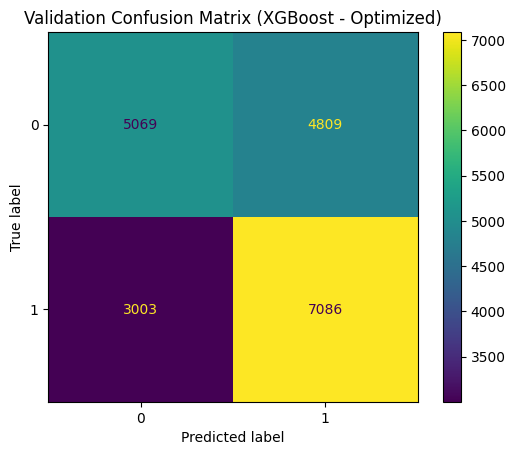

In [46]:
# Define pipeline
xgb_pipeline = Pipeline([
    ("preprocessing", preprocessor),  
    ("classifier", xgb.XGBClassifier(
        objective="binary:logistic", 
        eval_metric="auc", 
        use_label_encoder=False,
        n_jobs=1,
        random_state=42
    ))
])

# Hyperparameter grid
param_dist_xgb = {
    "classifier__n_estimators": [30, 50],  
    "classifier__max_depth": [3, 5, 7],  
    "classifier__learning_rate": [0.01, 0.05, 0.1],  
    "classifier__subsample": [0.7, 0.8],  
    "classifier__colsample_bytree": [0.7, 0.8],  
}

# Randomized Search
random_search_xgb = RandomizedSearchCV(
    xgb_pipeline, param_dist_xgb, 
    cv=2, scoring="roc_auc", n_jobs=1, n_iter=5, random_state=42
)

# Fit the model
random_search_xgb.fit(X_train, y_train)

# Best parameters & score
print("🛠️ Best XGBoost Params:", random_search_xgb.best_params_)
print(f"📈 Best ROC AUC from CV: {random_search_xgb.best_score_:.4f}")

# --- Training Predictions ---
y_train_pred = random_search_xgb.best_estimator_.predict(X_train)
y_train_pred_proba = random_search_xgb.best_estimator_.predict_proba(X_train)[:, 1]

# --- Validation Predictions ---
y_val_pred = random_search_xgb.best_estimator_.predict(X_val)
y_val_pred_proba = random_search_xgb.best_estimator_.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print("\n Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Confusion matrix - training
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train) 
disp_train.plot()
plt.title("Training Confusion Matrix (XGBoost - Optimized)")
plt.show()

# --- Validation Metrics ---
print("\n Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix - validation
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix (XGBoost - Optimized)")
plt.show()


* xgboost: Implements the XGBoost algorithm, an efficient gradient boosting method.

* RandomizedSearchCV: Performs hyperparameter tuning using random sampling.

Pipeline Purpose:

* Ensures preprocessing (e.g., scaling, encoding) is applied consistently.

* Trains XGBoost after preprocessing.

XGBoost Classifier Parameters:

* objective="binary:logistic" → Used for binary classification.

* eval_metric="auc" → Evaluates performance using the AUC (Area Under ROC Curve).

* use_label_encoder=False → Disables label encoding warning in newer XGBoost versions.

* n_jobs=1 → Uses 1 CPU core for training.

* n_estimators → Number of boosting rounds (trees).

* max_depth → Limits tree depth to prevent overfitting.

* learning_rate → Smaller values slow down learning but improve generalization.

* subsample → Fraction of rows used in each boosting round.

* colsample_bytree → Fraction of features used per tree.


param_dist_xgb = {
    "classifier__n_estimators": [30, 50],               # 2 options
    "classifier__max_depth": [3, 5, 7],                 # 3 options
    "classifier__learning_rate": [0.01, 0.05, 0.1],     # 3 options
    "classifier__subsample": [0.7, 0.8],                # 2 options
    "classifier__colsample_bytree": [0.7, 0.8],         # 2 options
}
Total Possible Combinations (Full Grid)
We multiply the number of values per hyperparameter:

2 × 3 × 3 × 2 × 2 = 72 combinations.

RandomizedSearchCV with n_iter = 5
So, 5 random combinations will be selected out of 72 possible.

Cross-validation Used: cv = 2
Each of the 5 sampled combinations is evaluated using 2-fold CV.

Final Answer:
Total model fits = 5 combinations × 2 folds = 10 model runs

🛠️ Best MLP Parameters: {'classifier__solver': 'adam', 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (100, 50), 'classifier__alpha': 0.01, 'classifier__activation': 'tanh'}
📈 Best ROC AUC from CV: 0.5875

Training Metrics:
Accuracy: 0.6036
AUC: 0.6329
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59     39513
           1       0.60      0.63      0.62     40353

    accuracy                           0.60     79866
   macro avg       0.60      0.60      0.60     79866
weighted avg       0.60      0.60      0.60     79866



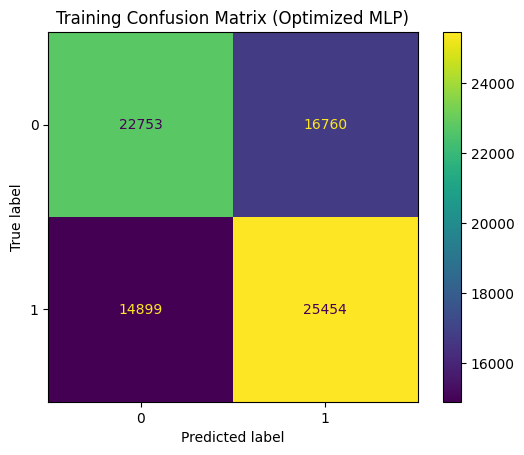


Validation Metrics:
Accuracy: 0.5936
AUC: 0.6265
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      9878
           1       0.59      0.62      0.61     10089

    accuracy                           0.59     19967
   macro avg       0.59      0.59      0.59     19967
weighted avg       0.59      0.59      0.59     19967



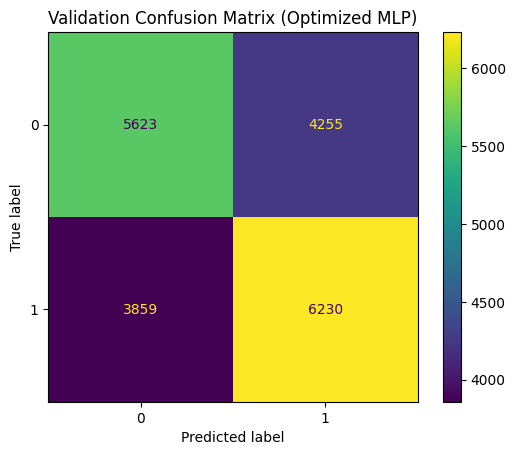

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# --- Define hyperparameter grid ---
param_dist_mlp = {
    "classifier__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "classifier__activation": ["relu", "tanh"],
    "classifier__solver": ["adam", "sgd"],
    "classifier__alpha": [0.0001, 0.001, 0.01],  # L2 penalty (regularization)
    "classifier__learning_rate": ["constant", "adaptive"],
}

# --- Define pipeline ---
mlp_pipeline = Pipeline([
    ("preprocessing", preprocessor),  
    ("classifier", MLPClassifier(max_iter=500, random_state=42))
])

# --- RandomizedSearchCV ---
random_search_mlp = RandomizedSearchCV(
    mlp_pipeline,
    param_distributions=param_dist_mlp,
    n_iter=5,
    scoring="roc_auc",
    cv=2,
    n_jobs=-1,
    random_state=42
)

# --- Fit the model ---
random_search_mlp.fit(X_train, y_train)

# --- Best params and score ---
print("🛠️ Best MLP Parameters:", random_search_mlp.best_params_)
print(f"📈 Best ROC AUC from CV: {random_search_mlp.best_score_:.4f}")

# --- Training Predictions ---
y_train_pred = random_search_mlp.best_estimator_.predict(X_train)
y_train_pred_proba = random_search_mlp.best_estimator_.predict_proba(X_train)[:, 1]

# --- Validation Predictions ---
y_val_pred = random_search_mlp.best_estimator_.predict(X_val)
y_val_pred_proba = random_search_mlp.best_estimator_.predict_proba(X_val)[:, 1]

# --- Training Metrics ---
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# --- Confusion Matrix - Training ---
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Training Confusion Matrix (Optimized MLP)")
plt.show()

# --- Validation Metrics ---
print("\nValidation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# --- Confusion Matrix - Validation ---
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix (Optimized MLP)")
plt.show()

In [11]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import (
#     accuracy_score, roc_auc_score, classification_report,
#     confusion_matrix, ConfusionMatrixDisplay
# )
# import matplotlib.pyplot as plt

# # --- Hyperparameter grid for GridSearchCV ---
# param_grid_mlp = {
#     "classifier__hidden_layer_sizes": [(50,), (100,), (50, 50)],
#     "classifier__activation": ["relu", "tanh"],
#     "classifier__solver": ["adam", "sgd"],
#     "classifier__alpha": [0.0001, 0.001],
#     "classifier__learning_rate": ["constant", "adaptive"]
# }

# # --- Define the pipeline ---
# mlp_pipeline = Pipeline([
#     ("preprocessing", preprocessor),
#     ("classifier", MLPClassifier(max_iter=500, random_state=42))
# ])

# # --- Grid Search ---
# grid_search_mlp = GridSearchCV(
#     estimator=mlp_pipeline,
#     param_grid=param_grid_mlp,
#     cv=2,
#     scoring="roc_auc",
#     n_jobs=-1,
#     verbose=1
# )

# # --- Fit the model ---
# grid_search_mlp.fit(X_train, y_train)

# # --- Best parameters and score ---
# print("🛠️ Best MLP Parameters:", grid_search_mlp.best_params_)
# print(f"📈 Best ROC AUC from CV: {grid_search_mlp.best_score_:.4f}")

# # --- Training Predictions ---
# y_train_pred = grid_search_mlp.best_estimator_.predict(X_train)
# y_train_pred_proba = grid_search_mlp.best_estimator_.predict_proba(X_train)[:, 1]

# # --- Validation Predictions ---
# y_val_pred = grid_search_mlp.best_estimator_.predict(X_val)
# y_val_pred_proba = grid_search_mlp.best_estimator_.predict_proba(X_val)[:, 1]

# # --- Training Metrics ---
# print("\nTraining Metrics:")
# print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
# print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
# print("Classification Report:")
# print(classification_report(y_train, y_train_pred))

# # --- Confusion Matrix - Training ---
# cm_train = confusion_matrix(y_train, y_train_pred)
# disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
# disp_train.plot()
# plt.title("Training Confusion Matrix (MLP - GridSearchCV)")
# plt.show()

# # --- Validation Metrics ---
# print("\nValidation Metrics:")
# print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
# print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
# print("Classification Report:")
# print(classification_report(y_val, y_val_pred))

# # --- Confusion Matrix - Validation ---
# cm_val = confusion_matrix(y_val, y_val_pred)
# disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
# disp_val.plot()
# plt.title("Validation Confusion Matrix (MLP - GridSearchCV)")
# plt.show()


## 🎯 Optimized LightGBM Model is performing well lets do some more twerks to it


 Training Metrics:
Accuracy: 0.7171
AUC: 0.7971
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     39513
           1       0.70      0.76      0.73     40353

    accuracy                           0.72     79866
   macro avg       0.72      0.72      0.72     79866
weighted avg       0.72      0.72      0.72     79866



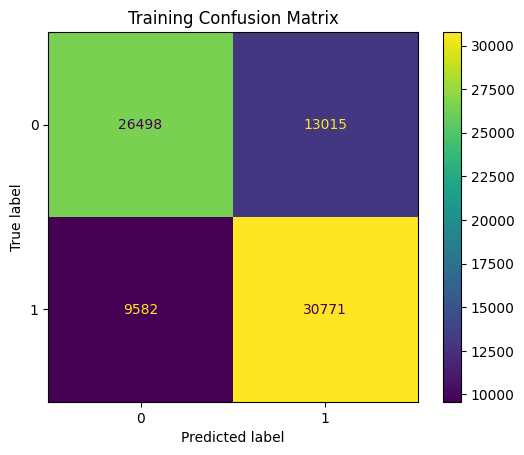


 Validation Metrics:
Accuracy: 0.6246
AUC: 0.6778
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.61      9878
           1       0.62      0.67      0.64     10089

    accuracy                           0.62     19967
   macro avg       0.63      0.62      0.62     19967
weighted avg       0.63      0.62      0.62     19967



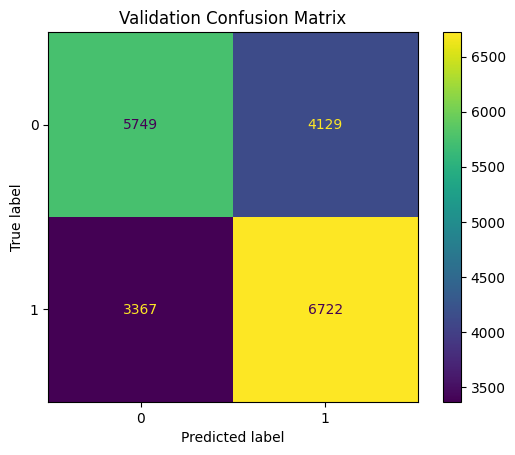


🔁 5-Fold Cross-Validation AUC: 0.6796 ± 0.0032


In [49]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Define the pipeline
lgb_model_optimized_1 = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", lgb.LGBMClassifier(
        n_estimators=1200,       
        learning_rate=0.01,      
        max_depth=14,            
        num_leaves=80,           
        min_child_samples=50,    
        colsample_bytree=0.8,    
        subsample=0.8,           
        reg_alpha=0.5,           
        reg_lambda=0.7,          
        min_split_gain=0.05,     
        boosting_type="gbdt",    
        random_state=42,
        verbose=-1
    ))
])

# Fit the model
lgb_model_optimized_1.fit(X_train, y_train)

# Training predictions
y_train_pred = lgb_model_optimized_1.predict(X_train)
y_train_pred_proba = lgb_model_optimized_1.predict_proba(X_train)[:, 1]

# Validation predictions
y_val_pred = lgb_model_optimized_1.predict(X_val)
y_val_pred_proba = lgb_model_optimized_1.predict_proba(X_val)[:, 1]

# Training metrics
print("\n Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Training confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Training Confusion Matrix")
plt.show()

# Validation metrics
print("\n Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Validation confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix")
plt.show()

# Cross-validation AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgb_model_optimized_1, X, y, cv=cv, scoring='roc_auc')

print(f"\n🔁 5-Fold Cross-Validation AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Best Parameters:
{'classifier__subsample': 0.8, 'classifier__reg_lambda': 0.0, 'classifier__reg_alpha': 0.0, 'classifier__num_leaves': 50, 'classifier__n_estimators': 500, 'classifier__min_split_gain': 0.05, 'classifier__min_child_samples': 100, 'classifier__max_depth': 14, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.7, 'classifier__boosting_type': 'gbdt'}
Best CV AUC Score: 0.6748

 Training Metrics:
Accuracy: 0.6525
AUC: 0.7142
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.59      0.63     39513
           1       0.64      0.71      0.67     40353

    accuracy                           0.65     79866
   macro avg       0.65      0.65      0.65     79866
weighted avg       0.65      0.65      0.65     79866



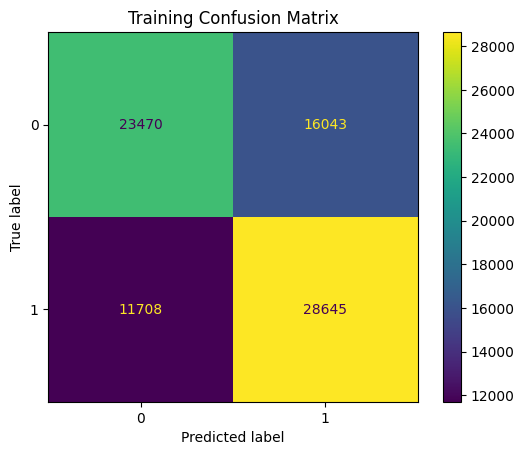


 Validation Metrics:
Accuracy: 0.6216
AUC: 0.6732
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      9878
           1       0.61      0.67      0.64     10089

    accuracy                           0.62     19967
   macro avg       0.62      0.62      0.62     19967
weighted avg       0.62      0.62      0.62     19967



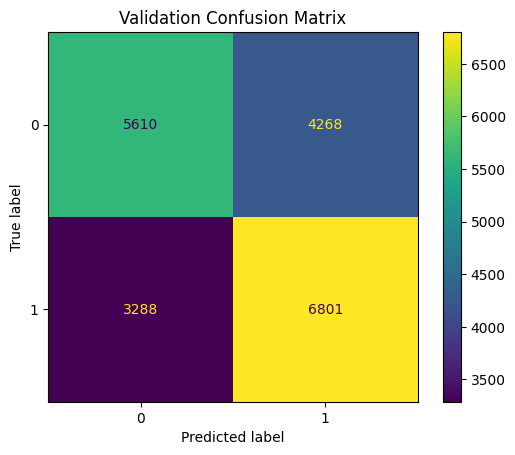


🔁 5-Fold Cross-Validation AUC: 0.6763 ± 0.0035


In [51]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define the pipeline
lgb_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", lgb.LGBMClassifier(random_state=42, verbose=-1))
])

# Define the hyperparameter search space
param_dist_lgb = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 300, 500,],
    'classifier__max_depth': [7, 10, 14],
    'classifier__num_leaves': [30, 50, 80],
    'classifier__min_child_samples': [20, 50, 100],
    'classifier__reg_alpha': [0.0, 0.3, 0.5],
    'classifier__reg_lambda': [0.0, 0.5, 0.7],
    'classifier__min_split_gain': [0.0, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__boosting_type': ['gbdt', 'dart']
}


# Randomized Search CV
random_search_lgb = RandomizedSearchCV(
    lgb_pipeline, param_distributions=param_dist_lgb,
    n_iter=10, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1
)

# Fit the randomized search model
random_search_lgb.fit(X_train, y_train)

# Best estimator after HPT
best_model = random_search_lgb.best_estimator_

# Print best params and score
print("\n Best Parameters:")
print(random_search_lgb.best_params_)
print(f"Best CV AUC Score: {random_search_lgb.best_score_:.4f}")

# Predictions
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Training Metrics
print("\n Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Training Confusion Matrix")
plt.show()

# Validation Metrics
print("\n Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("Validation Confusion Matrix")
plt.show()

# Cross-Validation AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='roc_auc')

print(f"\n🔁 5-Fold Cross-Validation AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Best Parameters:
{'classifier__subsample': 1.0, 'classifier__reg_lambda': 0.7, 'classifier__reg_alpha': 0.5, 'classifier__num_leaves': 80, 'classifier__n_estimators': 1200, 'classifier__min_split_gain': 0.0, 'classifier__min_child_samples': 20, 'classifier__max_depth': 14, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8, 'classifier__boosting_type': 'dart'}
Best CV AUC Score: 0.6743

 Training Metrics:
Accuracy: 0.7552
AUC: 0.8429
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74     39513
           1       0.73      0.81      0.77     40353

    accuracy                           0.76     79866
   macro avg       0.76      0.75      0.75     79866
weighted avg       0.76      0.76      0.75     79866



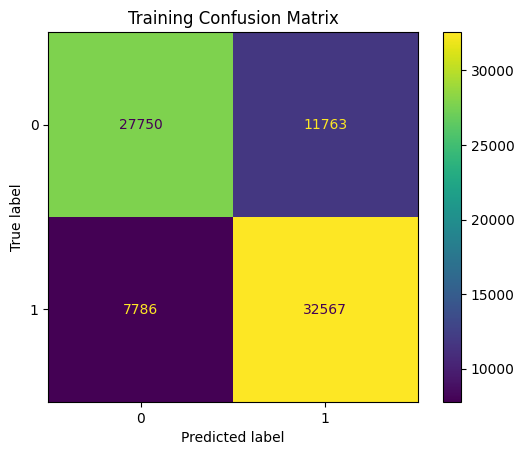


 Validation Metrics:
Accuracy: 0.6244
AUC: 0.6754
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.60      9878
           1       0.62      0.67      0.64     10089

    accuracy                           0.62     19967
   macro avg       0.63      0.62      0.62     19967
weighted avg       0.63      0.62      0.62     19967



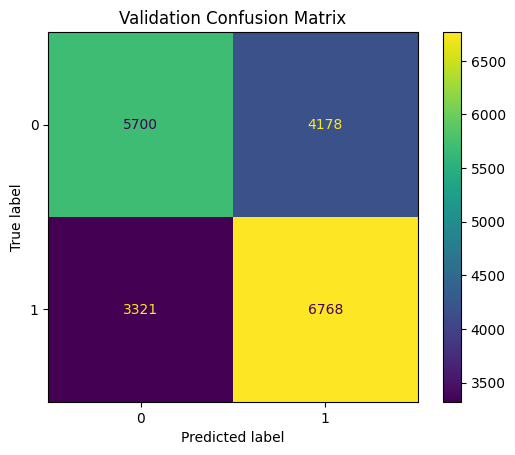


🔁 5-Fold Cross-Validation AUC: 0.6780 ± 0.0033


In [12]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define the pipeline
lgb_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", lgb.LGBMClassifier(random_state=42, verbose=-1))
])

# Define the hyperparameter search space
param_dist_lgb = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 300, 500, 1200],
    'classifier__max_depth': [7, 10, 14],
    'classifier__num_leaves': [30, 50, 80],
    'classifier__min_child_samples': [20, 50, 100],
    'classifier__reg_alpha': [0.0, 0.3, 0.5],
    'classifier__reg_lambda': [0.0, 0.5, 0.7],
    'classifier__min_split_gain': [0.0, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__boosting_type': ['gbdt', 'dart']
}


# Randomized Search CV
random_search_lgb = RandomizedSearchCV(
    lgb_pipeline, param_distributions=param_dist_lgb,
    n_iter=10, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1
)

# Fit the randomized search model
random_search_lgb.fit(X_train, y_train)

# Best estimator after HPT
best_model = random_search_lgb.best_estimator_

# Print best params and score
print("\n Best Parameters:")
print(random_search_lgb.best_params_)
print(f"Best CV AUC Score: {random_search_lgb.best_score_:.4f}")

# Predictions
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Training Metrics
print("\n Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Training Confusion Matrix")
plt.show()

# Validation Metrics
print("\n Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("Validation Confusion Matrix")
plt.show()

# Cross-Validation AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='roc_auc')

print(f"\n🔁 5-Fold Cross-Validation AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

## 🎯 Model Comparision graphs

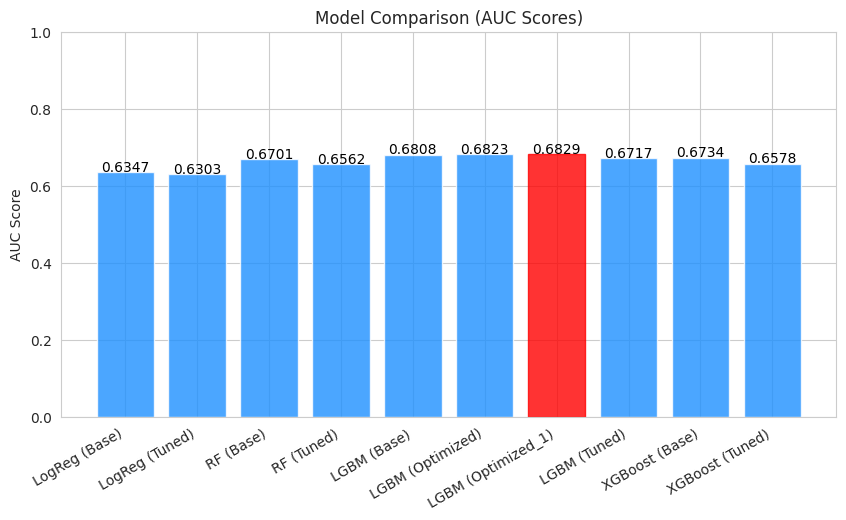

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model names
models = [
    "LogReg (Base)", "LogReg (Tuned)",
    "RF (Base)", "RF (Tuned)",
    "LGBM (Base)", "LGBM (Optimized)","LGBM (Optimized_1)" ,"LGBM (Tuned)",
    "XGBoost (Base)", "XGBoost (Tuned)"
]

# AUC Scores
auc_scores = [0.6347, 0.6303, 0.6701, 0.6562, 0.6808, 0.6823,0.6829, 0.6717, 0.6734, 0.6578]

# Plot settings
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# Bar plot for AUC scores
bars = plt.bar(models, auc_scores, color="dodgerblue", alpha=0.8)

# X-axis labels
plt.xticks(rotation=30, ha="right")

# Labels and title
plt.ylabel("AUC Score")
plt.title("Model Comparison (AUC Scores)")
plt.ylim(0, 1)  # Adjust y-axis for better visibility

# Highlighting the best model
best_model_idx = np.argmax(auc_scores)
bars[best_model_idx].set_color("red")  # Highlight best model in red

# Show values on top of bars
for bar, auc in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002, f"{auc:.4f}", ha='center', fontsize=10, color='black')

# Show plot
plt.show()

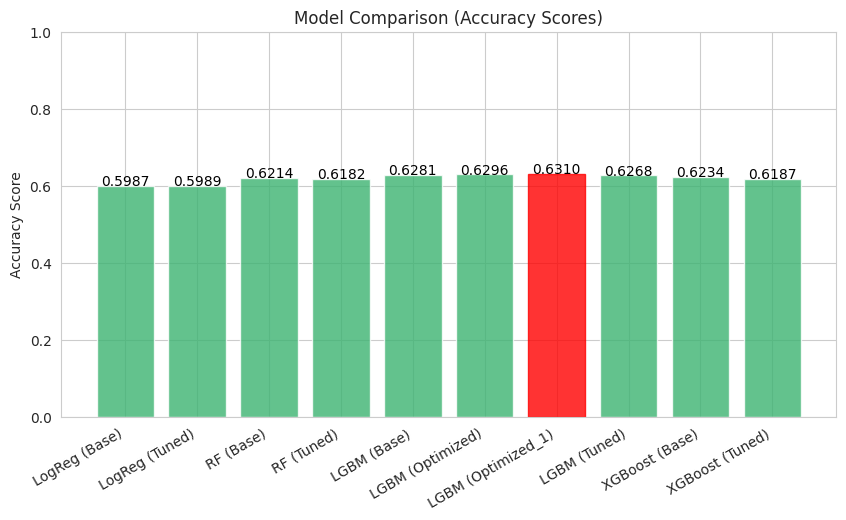

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model names
models = [
    "LogReg (Base)", "LogReg (Tuned)",
    "RF (Base)", "RF (Tuned)",
    "LGBM (Base)", "LGBM (Optimized)", "LGBM (Optimized_1)", "LGBM (Tuned)",
    "XGBoost (Base)", "XGBoost (Tuned)"
]

# Accuracy scores
accuracy_scores = [0.5987, 0.5989, 0.6214, 0.6182, 0.6281, 0.6296, 0.6310, 0.6268, 0.6234, 0.6187]

# Plot settings
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# Bar plot for accuracy scores
bars = plt.bar(models, accuracy_scores, color="mediumseagreen", alpha=0.8)

# X-axis labels
plt.xticks(rotation=30, ha="right")

# Labels and title
plt.ylabel("Accuracy Score")
plt.title("Model Comparison (Accuracy Scores)")
plt.ylim(0, 1)   


best_model_idx = np.argmax(accuracy_scores)
bars[best_model_idx].set_color("red")  

# Show values on top of bars
for bar, acc in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f"{acc:.4f}", ha='center', fontsize=10, color='black')

# Show plot
plt.show()

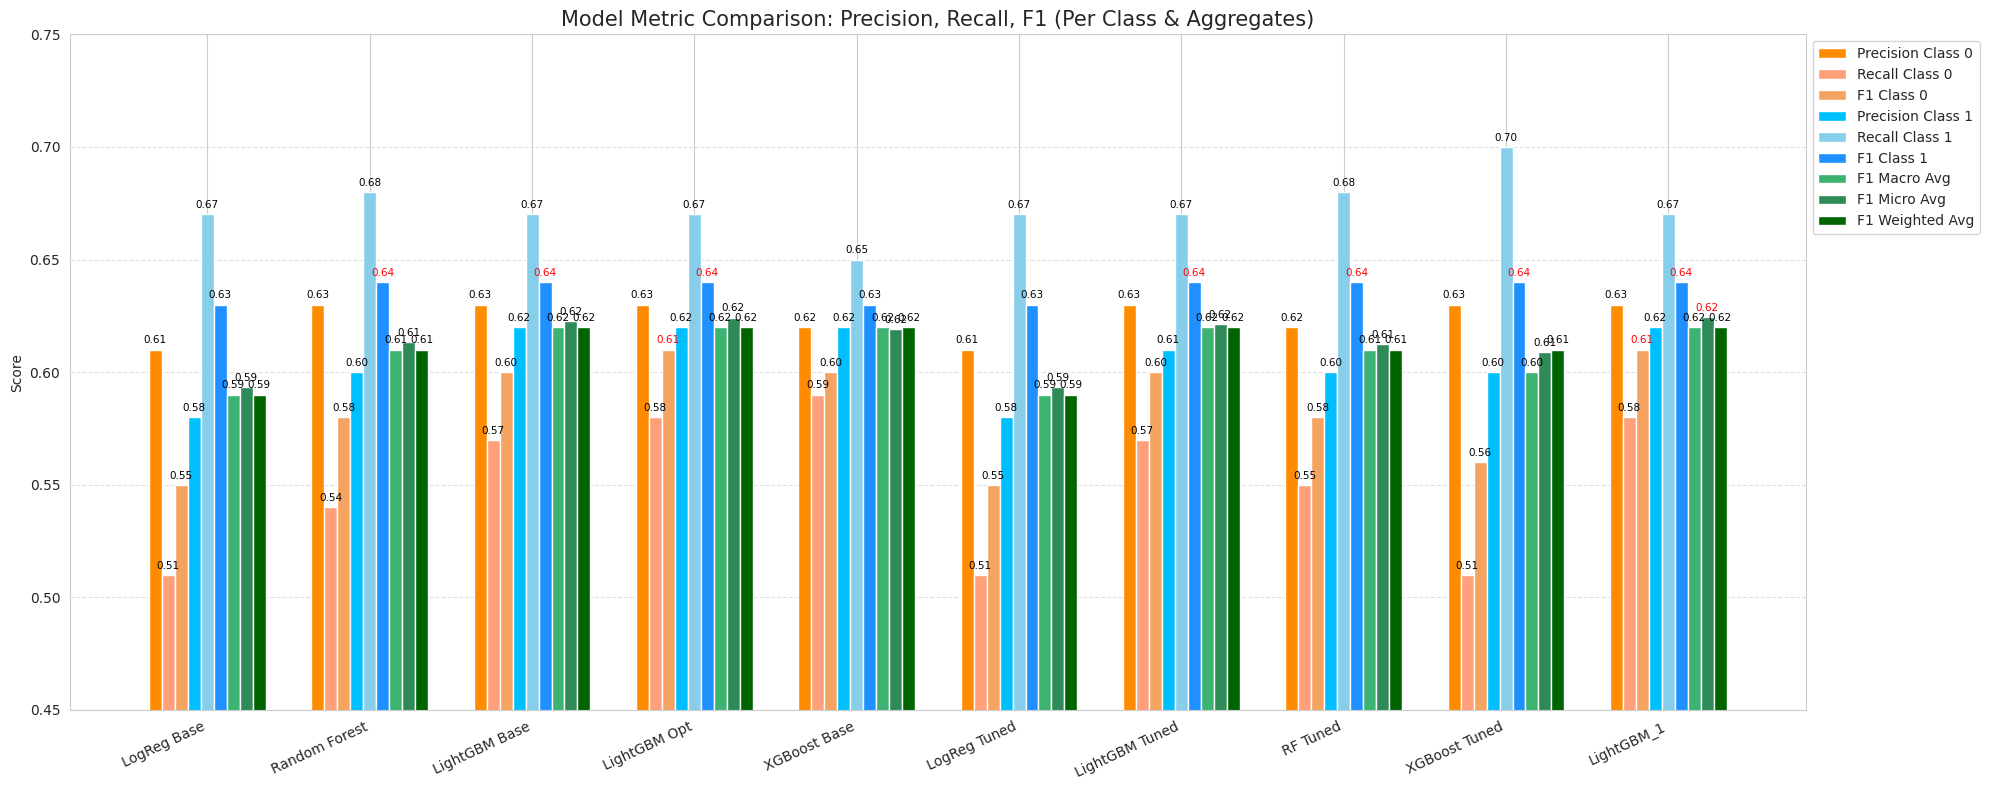

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = [
    "LogReg Base", "Random Forest", "LightGBM Base", "LightGBM Opt",
    "XGBoost Base", "LogReg Tuned", "LightGBM Tuned", "RF Tuned",
    "XGBoost Tuned", "LightGBM_1"
]

x = np.arange(len(models))
bar_width = 0.08

# Metrics from classification reports
precision_class_0 = [0.61, 0.63, 0.63, 0.63, 0.62, 0.61, 0.63, 0.62, 0.63, 0.63]
recall_class_0    = [0.51, 0.54, 0.57, 0.58, 0.59, 0.51, 0.57, 0.55, 0.51, 0.58]
f1_class_0        = [0.55, 0.58, 0.60, 0.61, 0.60, 0.55, 0.60, 0.58, 0.56, 0.61]

precision_class_1 = [0.58, 0.60, 0.62, 0.62, 0.62, 0.58, 0.61, 0.60, 0.60, 0.62]
recall_class_1    = [0.67, 0.68, 0.67, 0.67, 0.65, 0.67, 0.67, 0.68, 0.70, 0.67]
f1_class_1        = [0.63, 0.64, 0.64, 0.64, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64]

f1_macro_avg      = [0.59, 0.61, 0.62, 0.62, 0.62, 0.59, 0.62, 0.61, 0.60, 0.62]
f1_micro_avg      = [0.5932, 0.6133, 0.6226, 0.6242, 0.6191, 0.5934, 0.6214, 0.6123, 0.6088, 0.6246]
f1_weighted_avg   = [0.59, 0.61, 0.62, 0.62, 0.62, 0.59, 0.62, 0.61, 0.61, 0.62]

# Helper function to annotate bars
def annotate_bars(ax, bars, highlight_max=False):
    max_height = max([bar.get_height() for bar in bars])
    for bar in bars:
        height = bar.get_height()
        color = 'red' if highlight_max and height == max_height else 'black'
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7.5, color=color)

# Plot
fig, ax = plt.subplots(figsize=(20, 8))

# Grouped bar positions
bar1 = ax.bar(x - 4*bar_width, precision_class_0, width=bar_width, label='Precision Class 0', color='darkorange')
bar2 = ax.bar(x - 3*bar_width, recall_class_0, width=bar_width, label='Recall Class 0', color='lightsalmon')
bar3 = ax.bar(x - 2*bar_width, f1_class_0, width=bar_width, label='F1 Class 0', color='sandybrown')

bar4 = ax.bar(x - bar_width, precision_class_1, width=bar_width, label='Precision Class 1', color='deepskyblue')
bar5 = ax.bar(x, recall_class_1, width=bar_width, label='Recall Class 1', color='skyblue')
bar6 = ax.bar(x + bar_width, f1_class_1, width=bar_width, label='F1 Class 1', color='dodgerblue')

bar7 = ax.bar(x + 2*bar_width, f1_macro_avg, width=bar_width, label='F1 Macro Avg', color='mediumseagreen')
bar8 = ax.bar(x + 3*bar_width, f1_micro_avg, width=bar_width, label='F1 Micro Avg', color='seagreen')
bar9 = ax.bar(x + 4*bar_width, f1_weighted_avg, width=bar_width, label='F1 Weighted Avg', color='darkgreen')

# Annotations with max highlights
for i, bar_group in enumerate([bar1, bar2, bar3, bar4, bar5, bar6, bar7, bar8, bar9]):
    highlight = i in [2, 5, 7]  # highlight F1 class 0, class 1, micro avg
    annotate_bars(ax, bar_group, highlight_max=highlight)

# Plot aesthetics
ax.set_title("Model Metric Comparison: Precision, Recall, F1 (Per Class & Aggregates)", fontsize=15)
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, ha='right', fontsize=10)
ax.set_ylim(0.45, 0.75)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 🎯 Final Submission

In [99]:
# Preprocess Test Data and Make Predictions
X_test_processed = test_df.copy() 

y_test_pred_proba = lgb_model_optimized_1.predict_proba(X_test_processed)[:, 1] 
# Convert probabilities to binary classification (0 or 1)
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

# Create Submission File
submission = pd.DataFrame({
    "id": test_df.index,  
    "target": y_test_pred  
})

# Save the submission file
submission.to_csv("submission.csv", index=False)

print("Submission file saved as 'submission.csv'")

 Submission file saved as 'submission.csv'


## 🙏  *THANK YOU* 😊🎉

